In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from helperFunctions import createDataSet

In [22]:
file = "../../data/Ohio2020_processed/train/540-ws-training_processed.csv"
data = createDataSet(file)
data[0]

,missing_cbg,cbg,finger,basal,hr,gsr,carbInput,bolus,minAfterMeal,glucose_lag_1,glucose_lag_2
0,0.0,84.0,0.0,0.95,0.0,0.007625,57.0,0.0,0,106.0,121.0
10,0.0,78.0,0.0,0.95,0.0,0.000000,0.0,0.0,10,84.0,106.0
20,0.0,72.0,0.0,0.95,0.0,0.024066,0.0,0.0,20,78.0,84.0
30,0.0,68.0,0.0,0.95,0.0,0.006154,0.0,0.0,30,72.0,78.0
40,0.0,91.0,0.0,0.95,0.0,0.008535,0.0,6.3,40,68.0,72.0
50,0.0,136.0,0.0,0.95,0.0,0.011371,0.0,0.0,50,91.0,68.0
60,0.0,161.0,0.0,0.95,0.0,0.010671,0.0,0.0,60,136.0,91.0
70,0.0,175.0,0.0,0.95,0.0,0.012545,0.0,0.0,70,161.0,136.0
80,0.0,163.0,0.0,0.95,0.0,0.010346,0.0,0.0,80,175.0,161.0
90,0.0,138.0,0.0,0.95,0.0,0.015037,0.0,0.0,90,163.0,175.0


In [23]:
def train_model(data, model, train = True):
    # Random seed from reproducibility
    # random.Random(42).shuffle(carbIntake)
    # Perform train-test split on the combined DataFrame
    

    # Data is scaled using MinMaxScaler to ensure that all features are within the same range, typically between 0 and 1.
    scaler = MinMaxScaler()

    X_train = data.drop(["cbg"], axis=1)
    y_train = data["cbg"]

    carbInput = data[data["carbInput"] > 0]

    X_train_scaled = scaler.fit_transform(X_train)
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

    # Linear Regression
    # Train the linear regression model on the scaled data
    if train:
        model.fit(X_train_scaled, y_train_scaled.reshape(-1, 1))
    
    # Make predictions
    y_train_pred_scaled = model.predict(X_train_scaled).reshape(-1, 1)

    # Invert scaling
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled)

    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(X_train.index, y_train, label="Ground Truth")
    axs[0].plot(X_train.index,y_train_pred, label="Prediction")
    # axs[0].plot(carbInput.index, carbInput["carbInput"], "ro")
    axs2 = axs[0].twinx()
    axs2.plot(carbInput.index, carbInput["carbInput"], "ro", label="Carb intake")
    axs[1].bar(X_train.columns.values, model.coef_[0])

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    axs[0].legend(loc="upper center")

    return  model.coef_[0]
    

In [24]:
data_train, data_test = train_test_split(data, test_size=0.33, random_state=42)
data_train[0]

,missing_cbg,cbg,finger,basal,hr,gsr,carbInput,bolus,minAfterMeal,glucose_lag_1,glucose_lag_2
0,0.0,223.0,0.0,0.4,0.0,0.0,30.0,0.0,0,233.0,257.0
10,0.0,201.0,0.0,0.4,0.0,0.0,0.0,0.0,10,223.0,233.0
20,0.0,184.0,0.0,0.4,0.0,0.0,0.0,0.0,20,201.0,223.0
30,0.0,176.0,0.0,0.4,0.0,0.0,0.0,0.0,30,184.0,201.0
40,0.0,174.0,0.0,0.4,0.0,0.0,0.0,0.0,40,176.0,184.0
50,0.0,170.0,0.0,0.4,0.0,0.0,0.0,0.0,50,174.0,176.0
60,0.0,173.0,0.0,0.4,0.0,0.0,0.0,0.0,60,170.0,174.0
70,0.0,174.0,0.0,0.4,0.0,0.0,0.0,0.0,70,173.0,170.0
80,0.0,169.0,0.0,0.4,0.0,0.0,0.0,0.0,80,174.0,173.0
90,0.0,167.0,0.0,0.4,0.0,0.0,0.0,0.0,90,169.0,174.0


/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/sklearn/utils/valid

<Figure size 640x480 with 0 Axes>

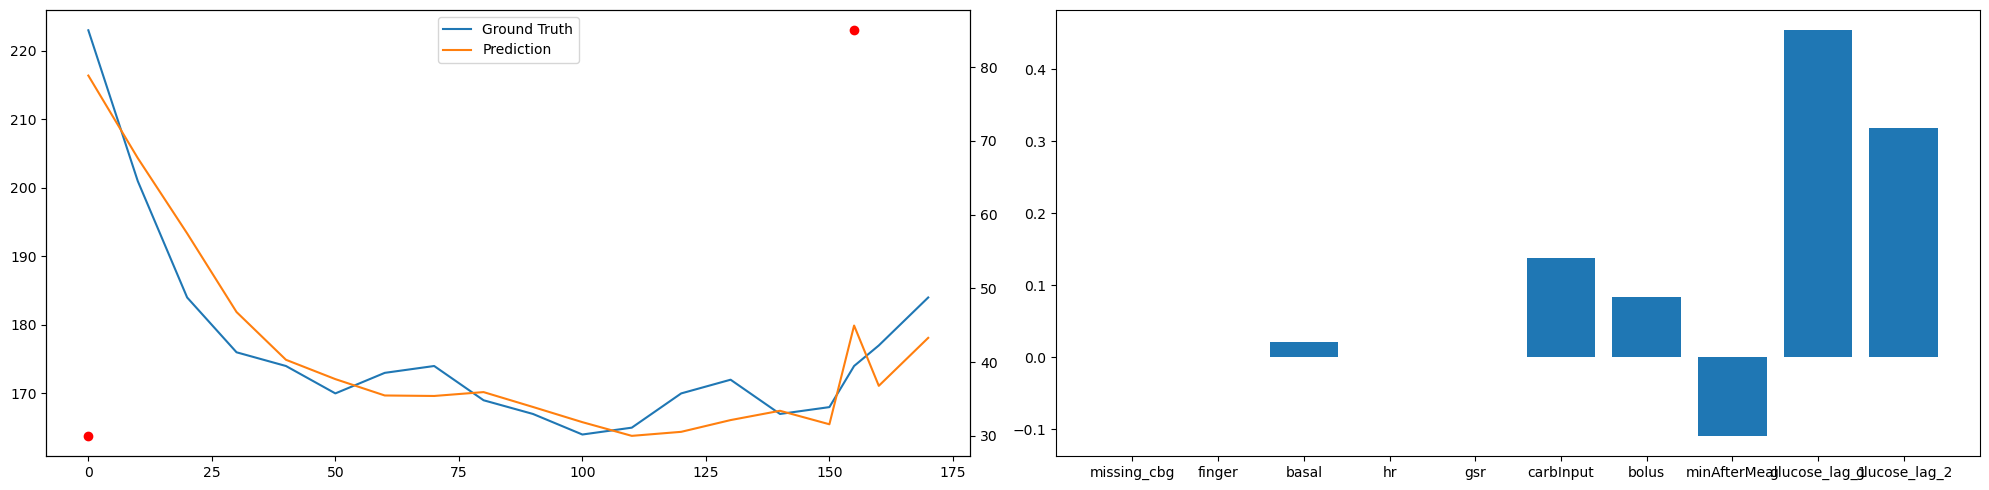

<Figure size 640x480 with 0 Axes>

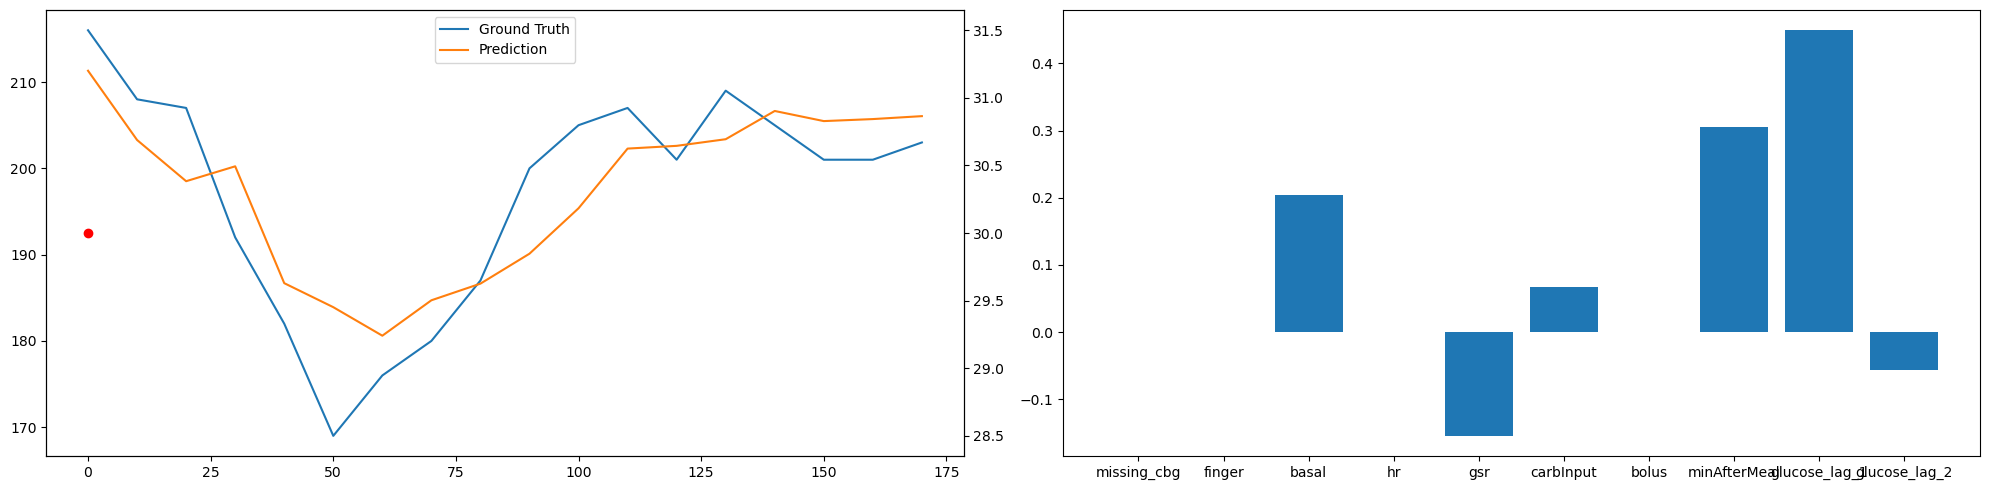

<Figure size 640x480 with 0 Axes>

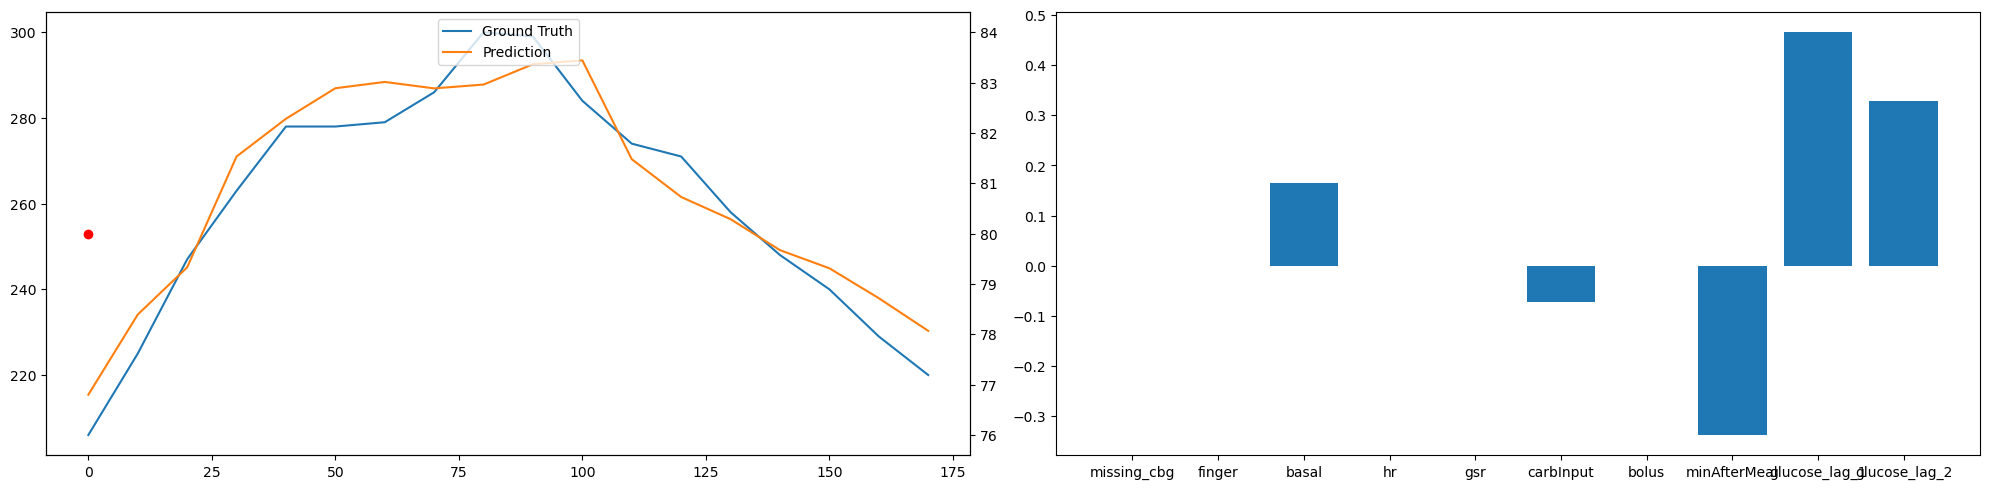

<Figure size 640x480 with 0 Axes>

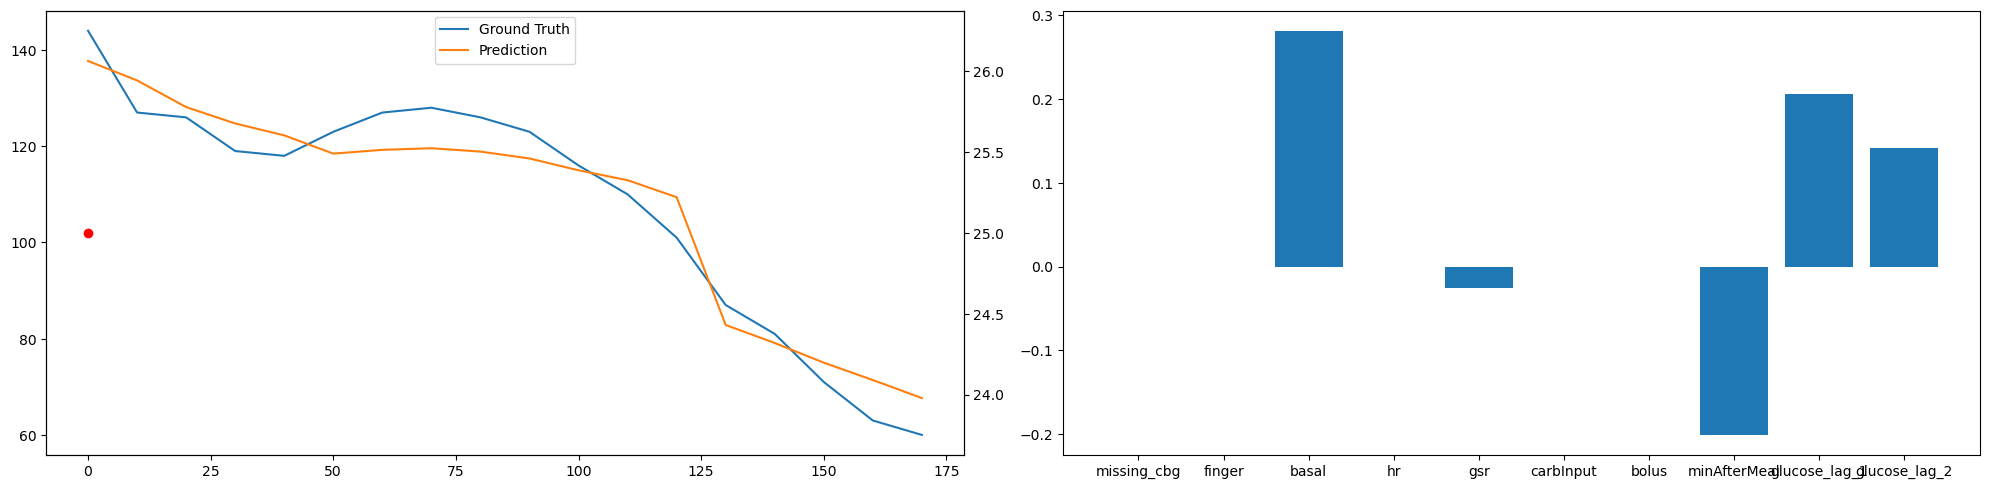

<Figure size 640x480 with 0 Axes>

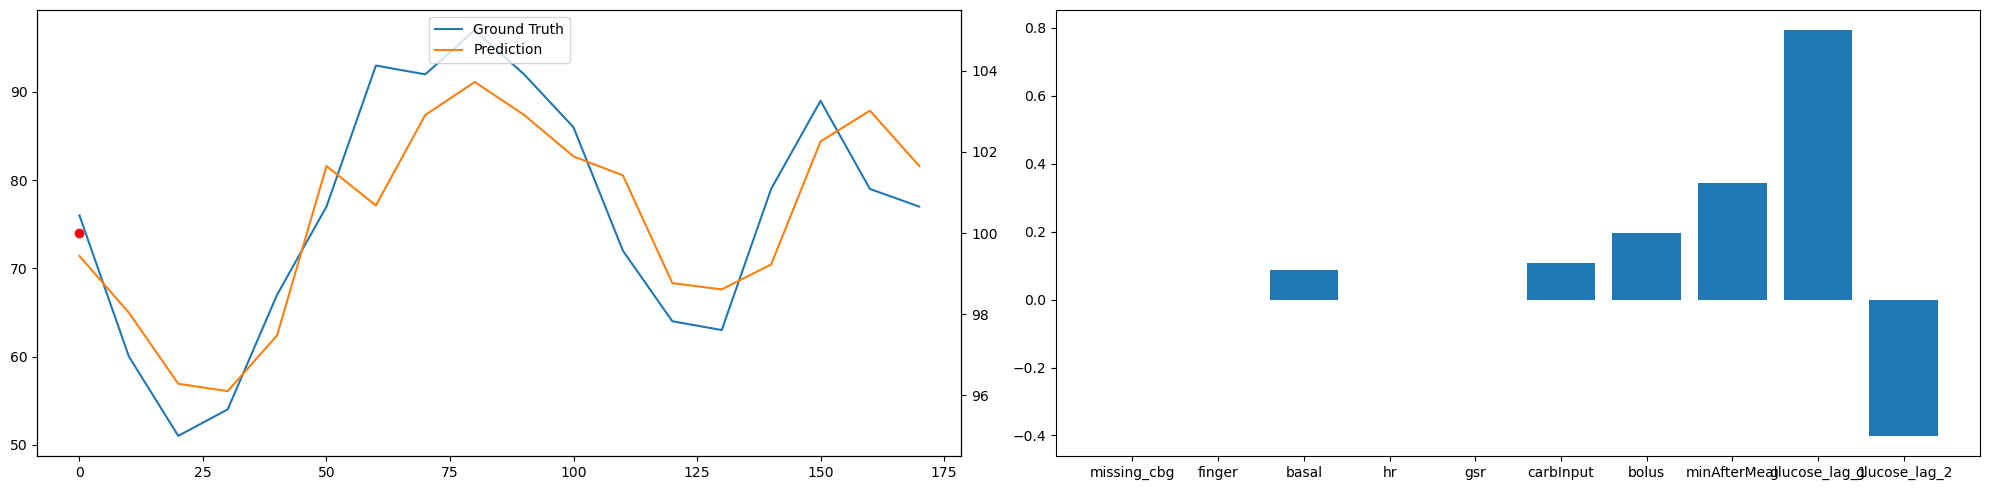

<Figure size 640x480 with 0 Axes>

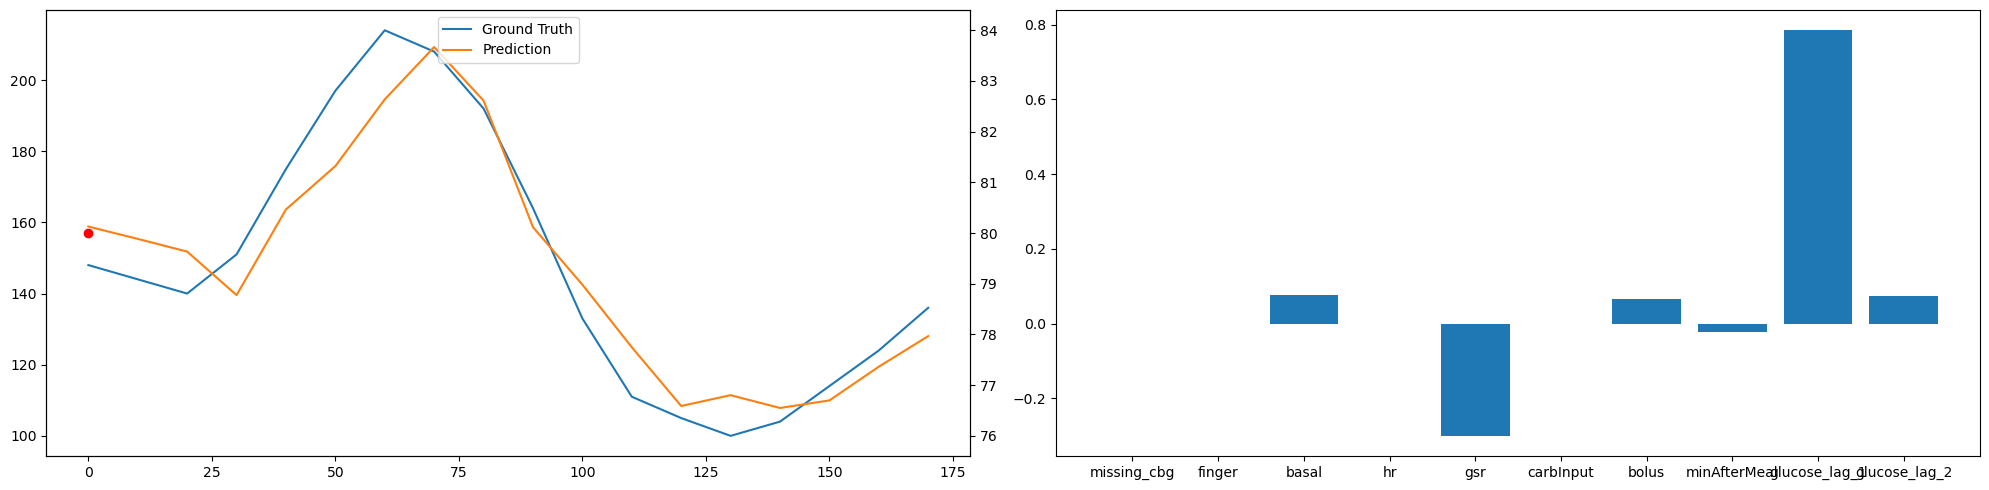

<Figure size 640x480 with 0 Axes>

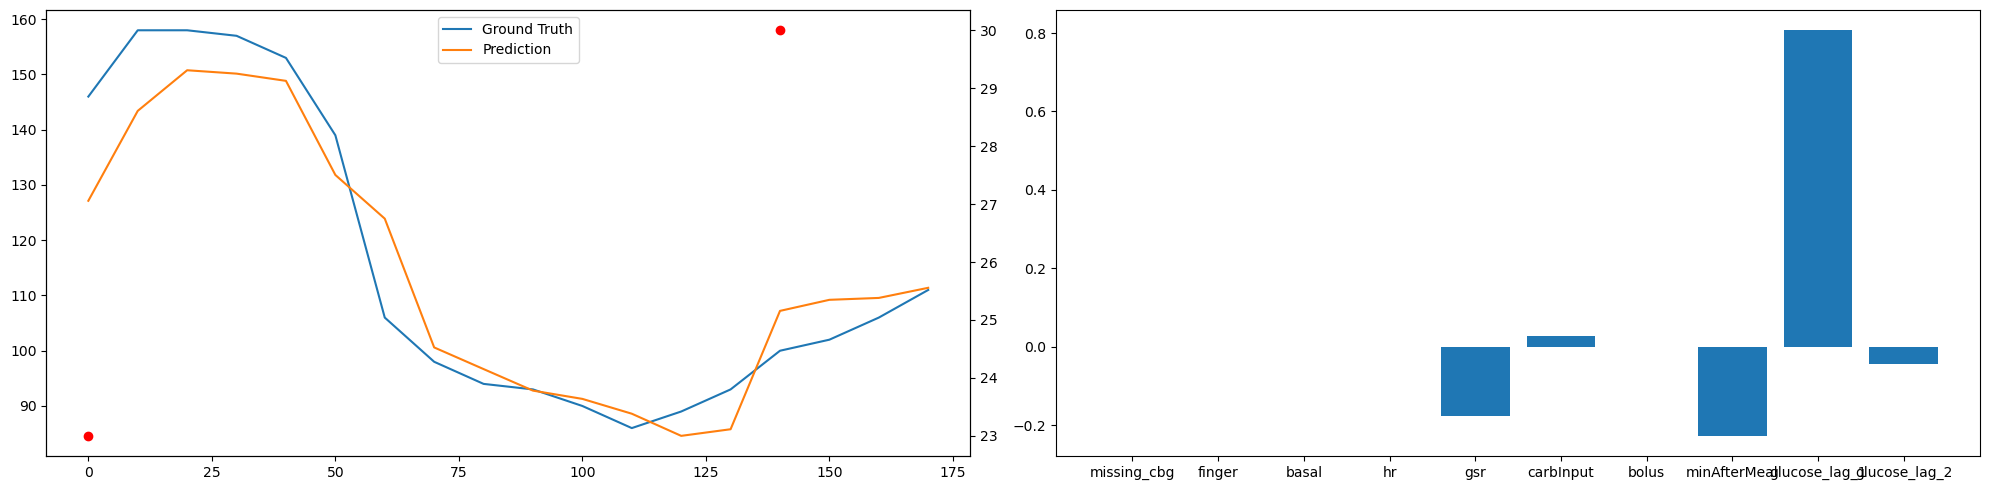

<Figure size 640x480 with 0 Axes>

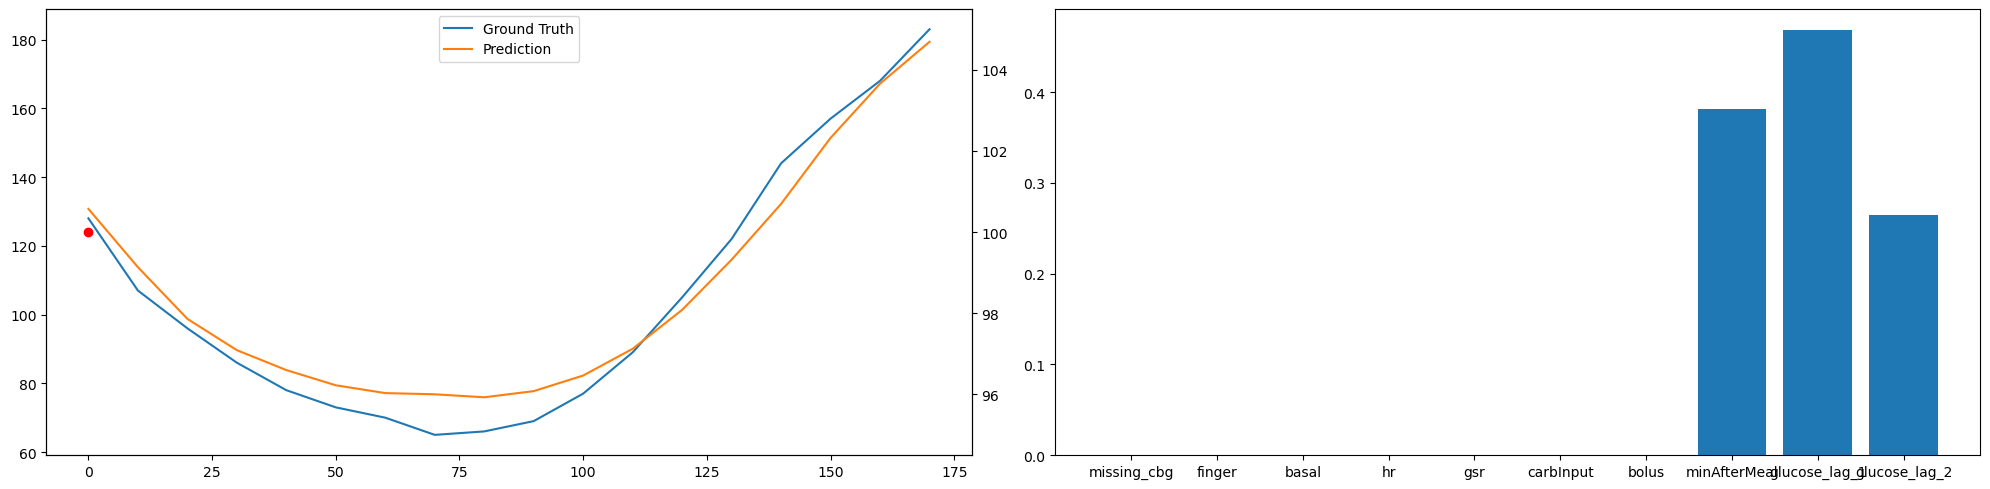

<Figure size 640x480 with 0 Axes>

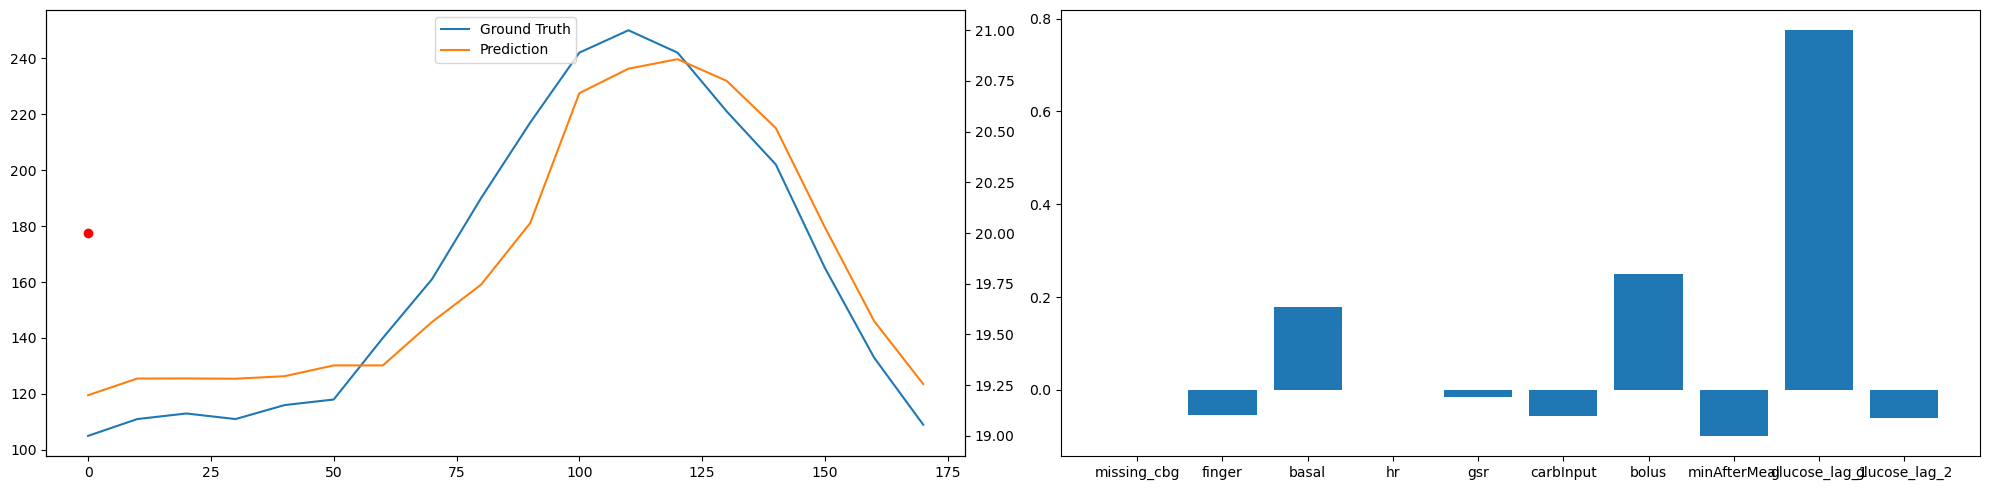

<Figure size 640x480 with 0 Axes>

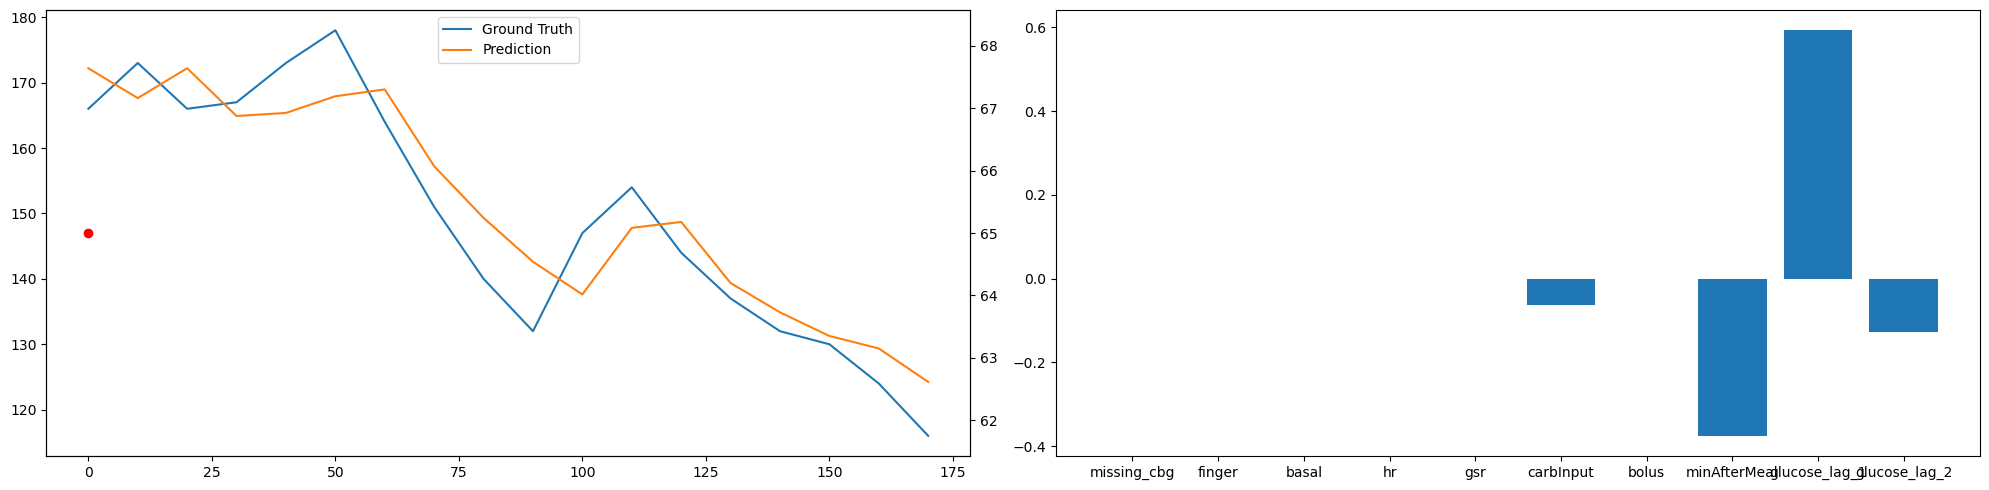

<Figure size 640x480 with 0 Axes>

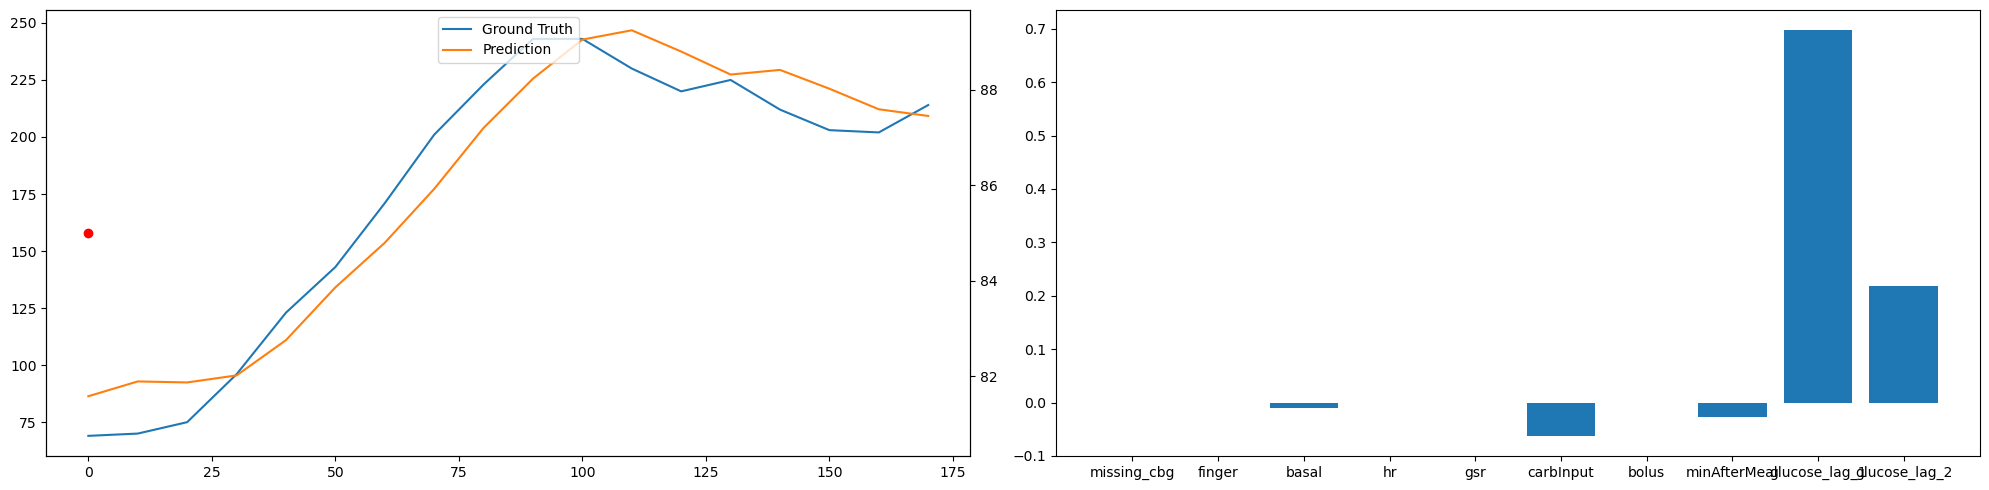

<Figure size 640x480 with 0 Axes>

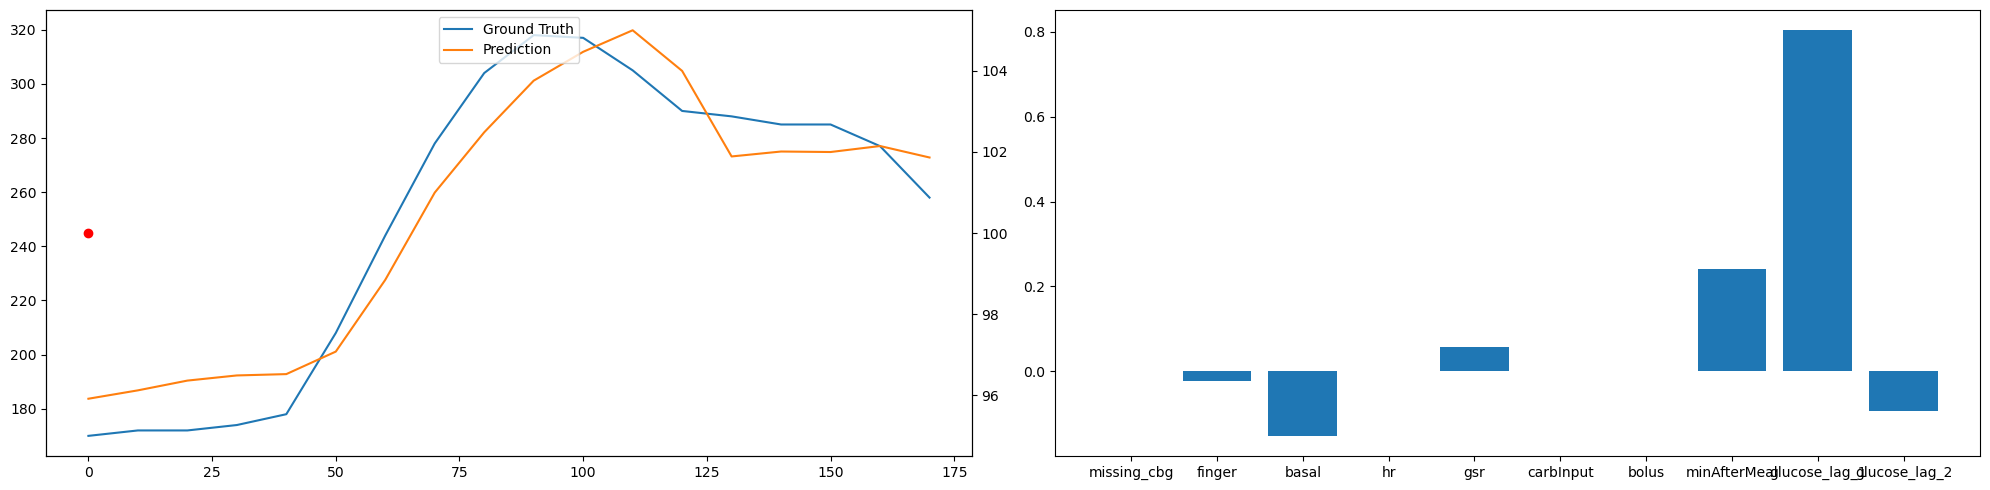

<Figure size 640x480 with 0 Axes>

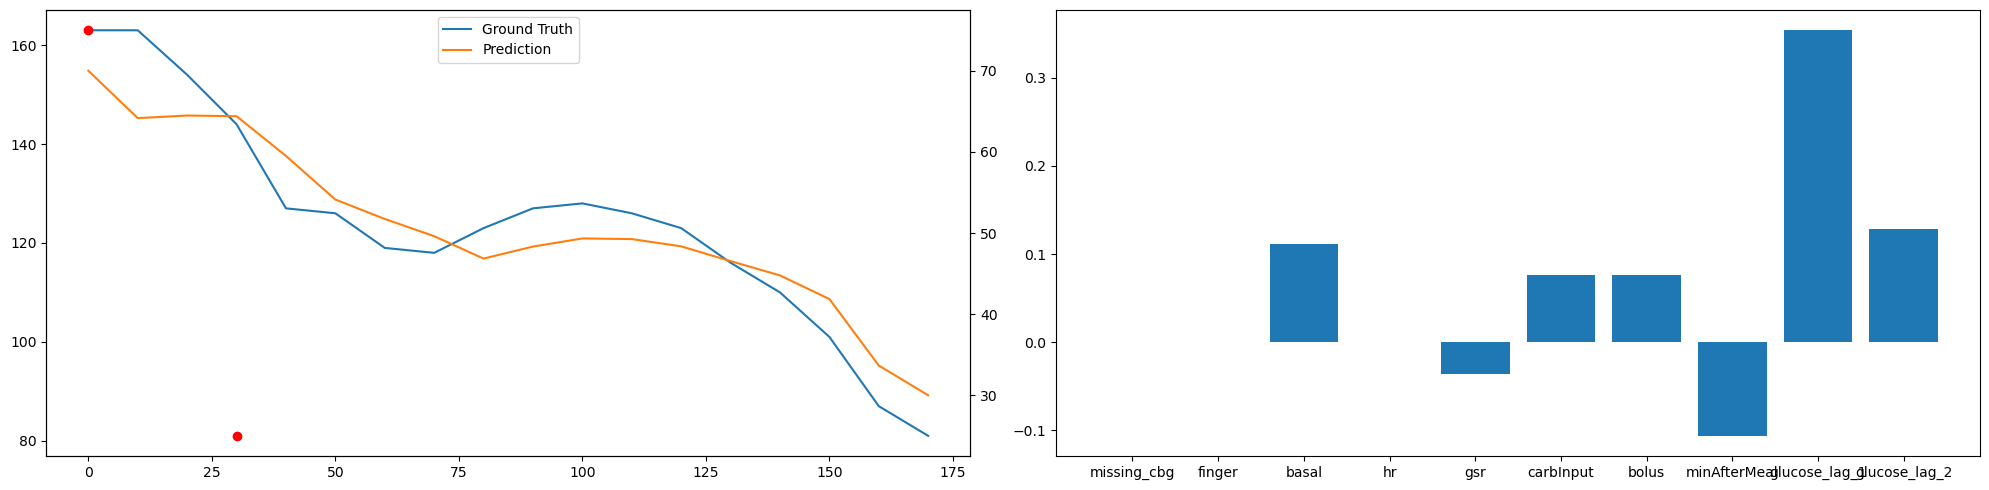

<Figure size 640x480 with 0 Axes>

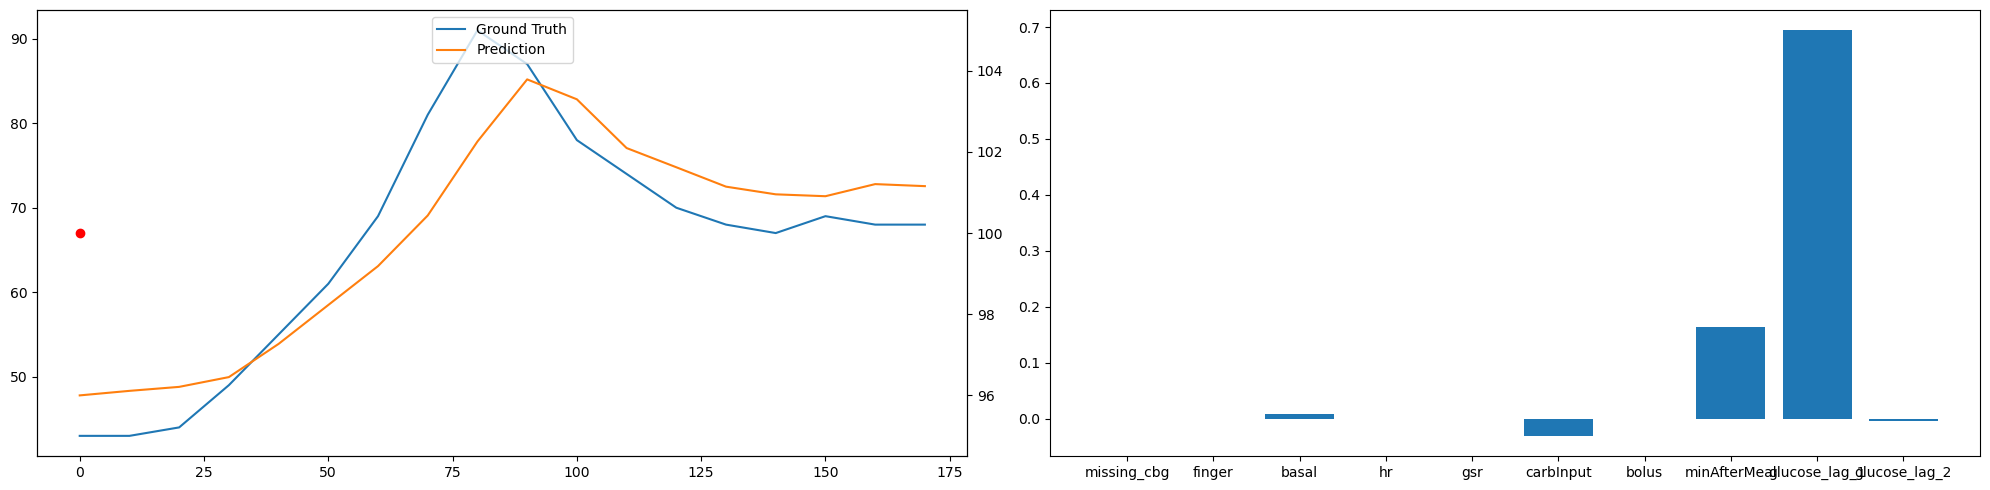

<Figure size 640x480 with 0 Axes>

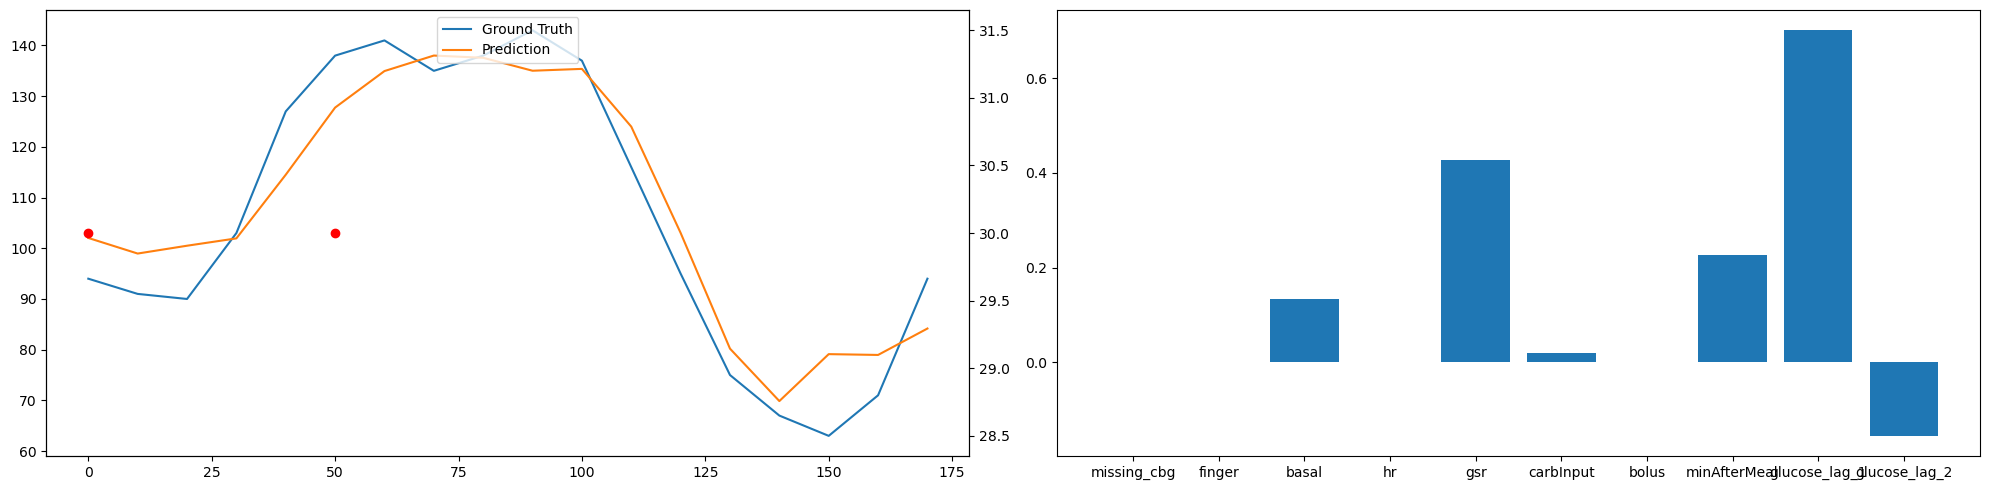

<Figure size 640x480 with 0 Axes>

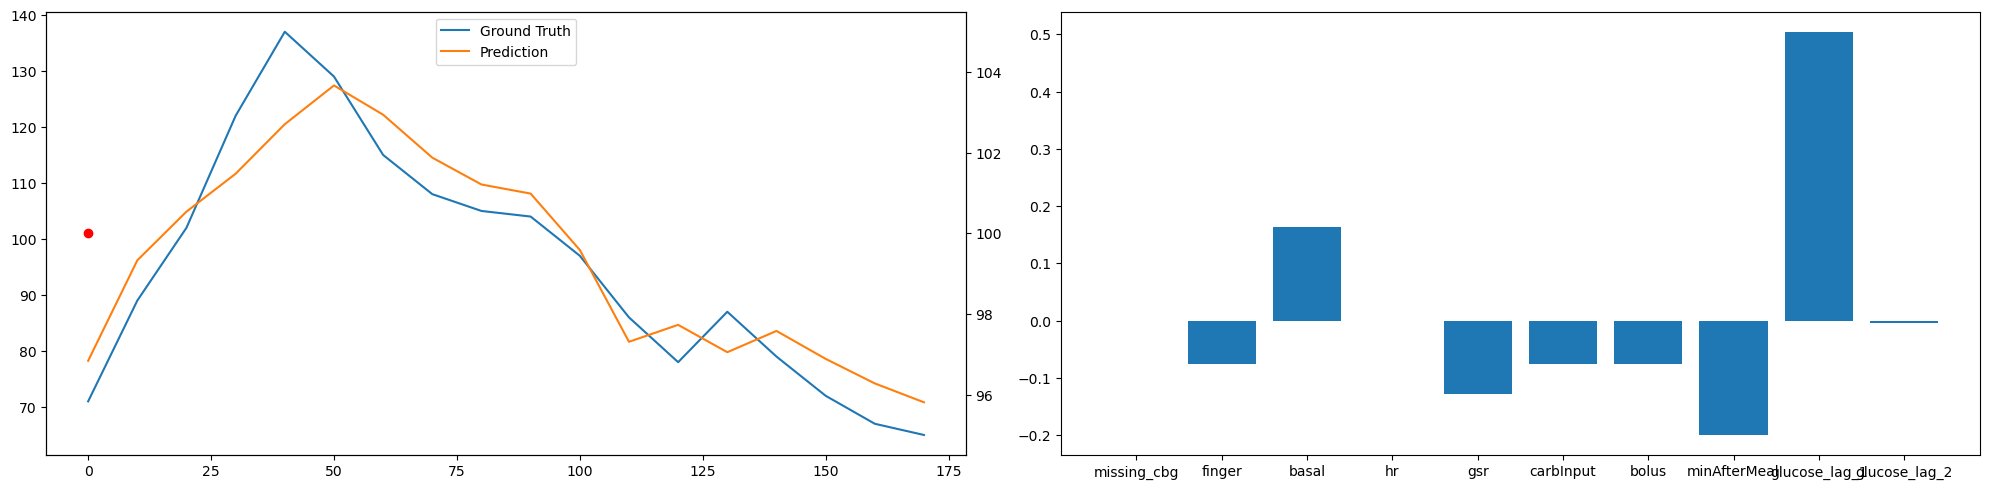

<Figure size 640x480 with 0 Axes>

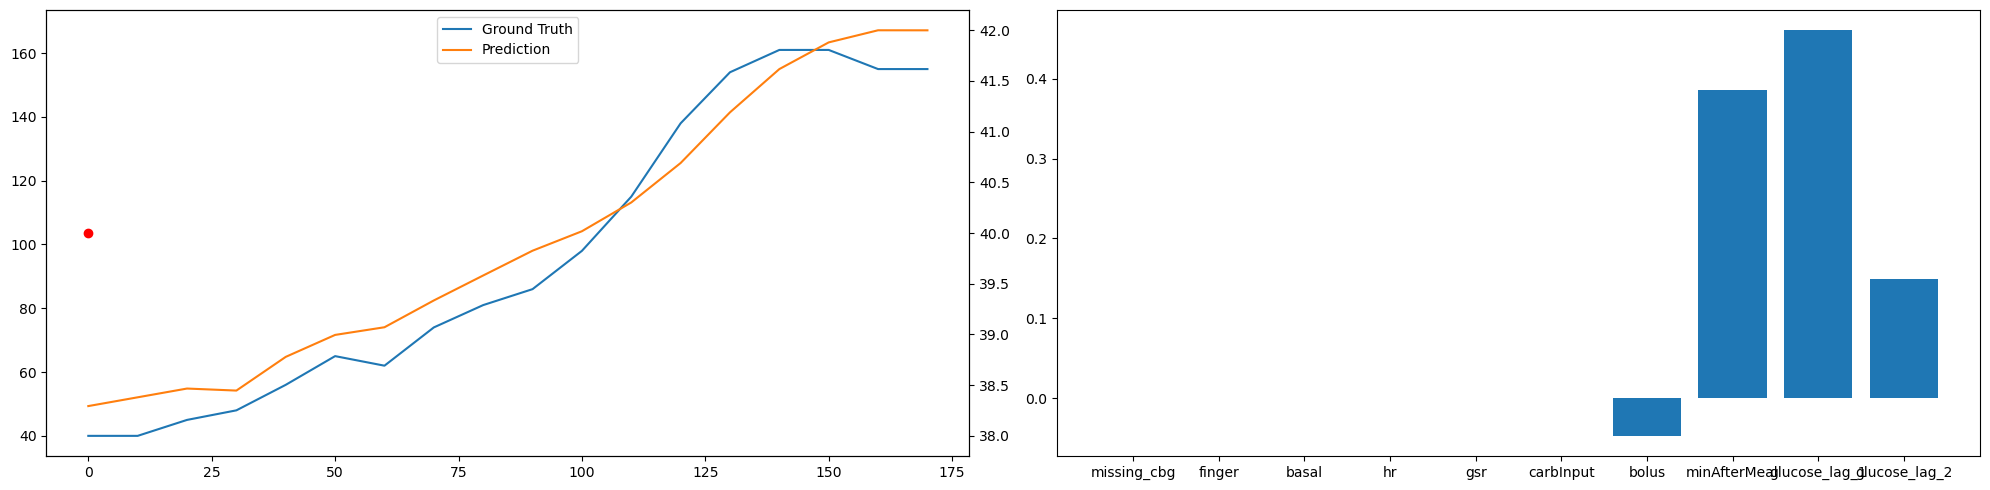

<Figure size 640x480 with 0 Axes>

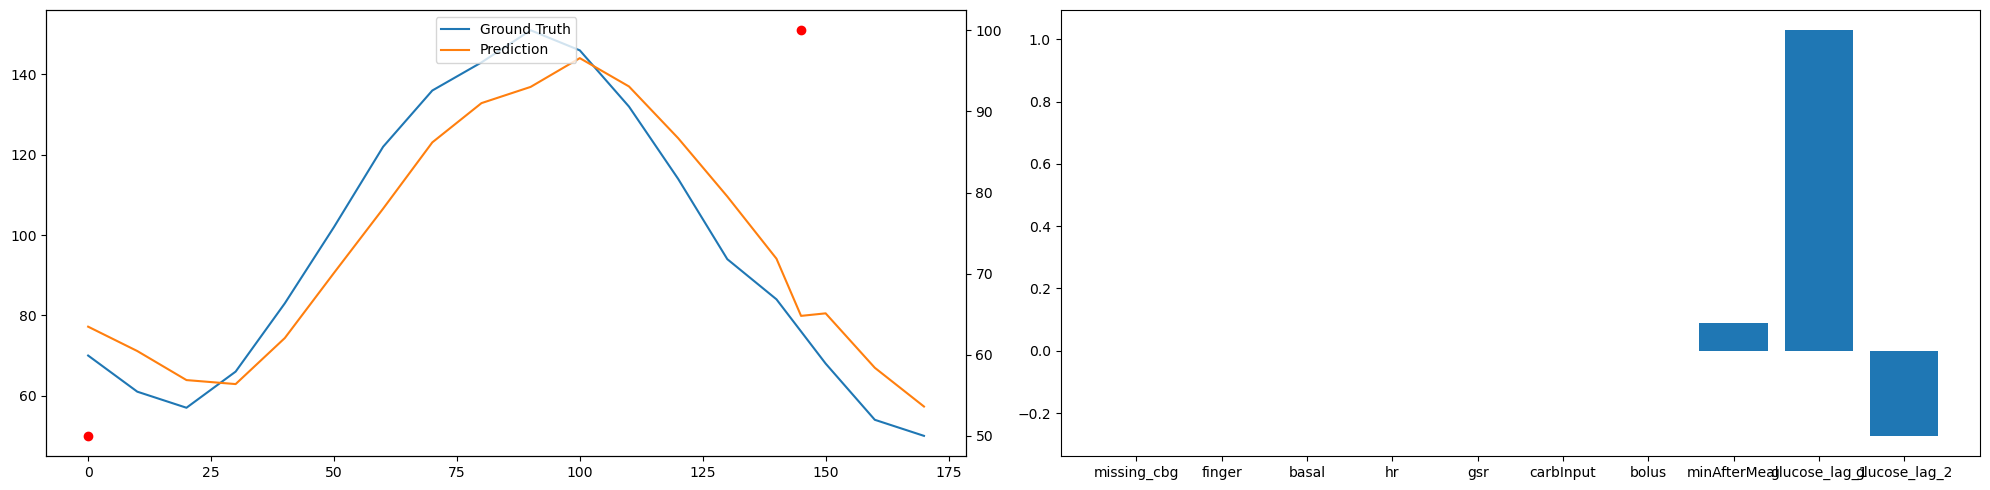

<Figure size 640x480 with 0 Axes>

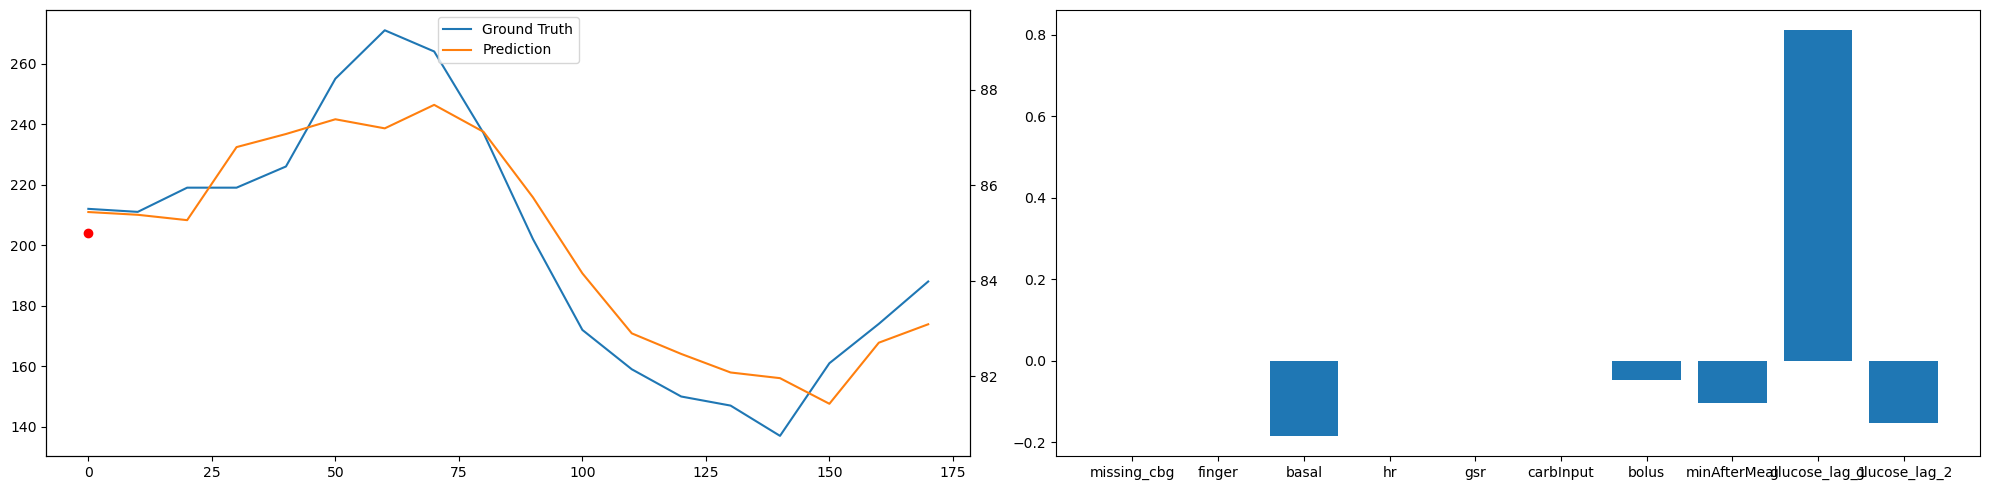

<Figure size 640x480 with 0 Axes>

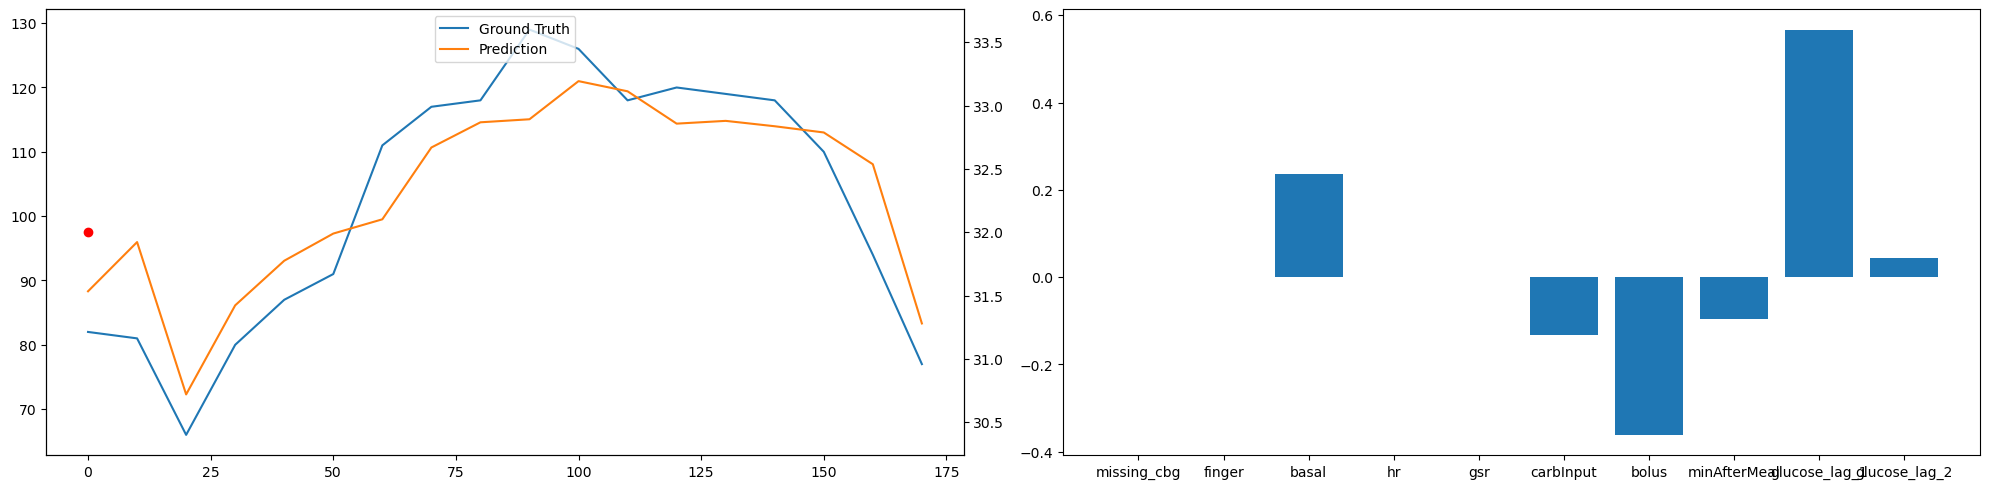

<Figure size 640x480 with 0 Axes>

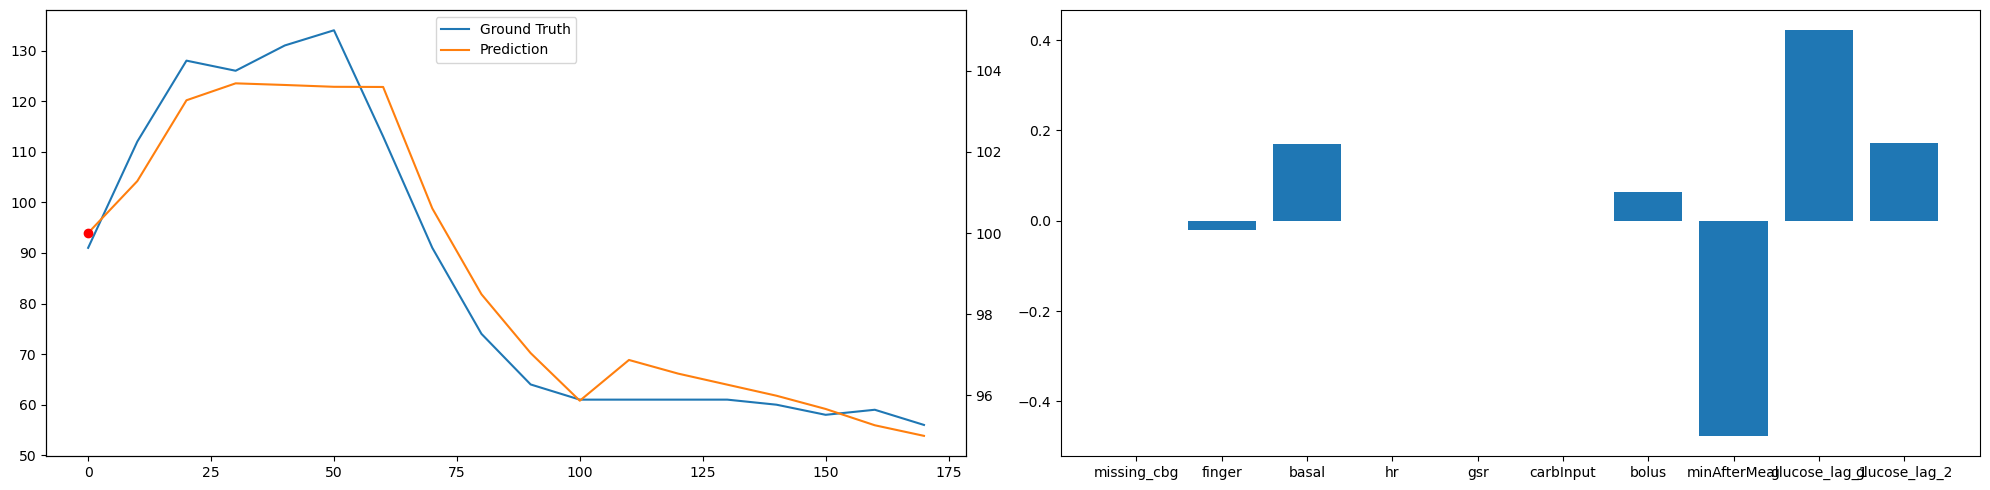

<Figure size 640x480 with 0 Axes>

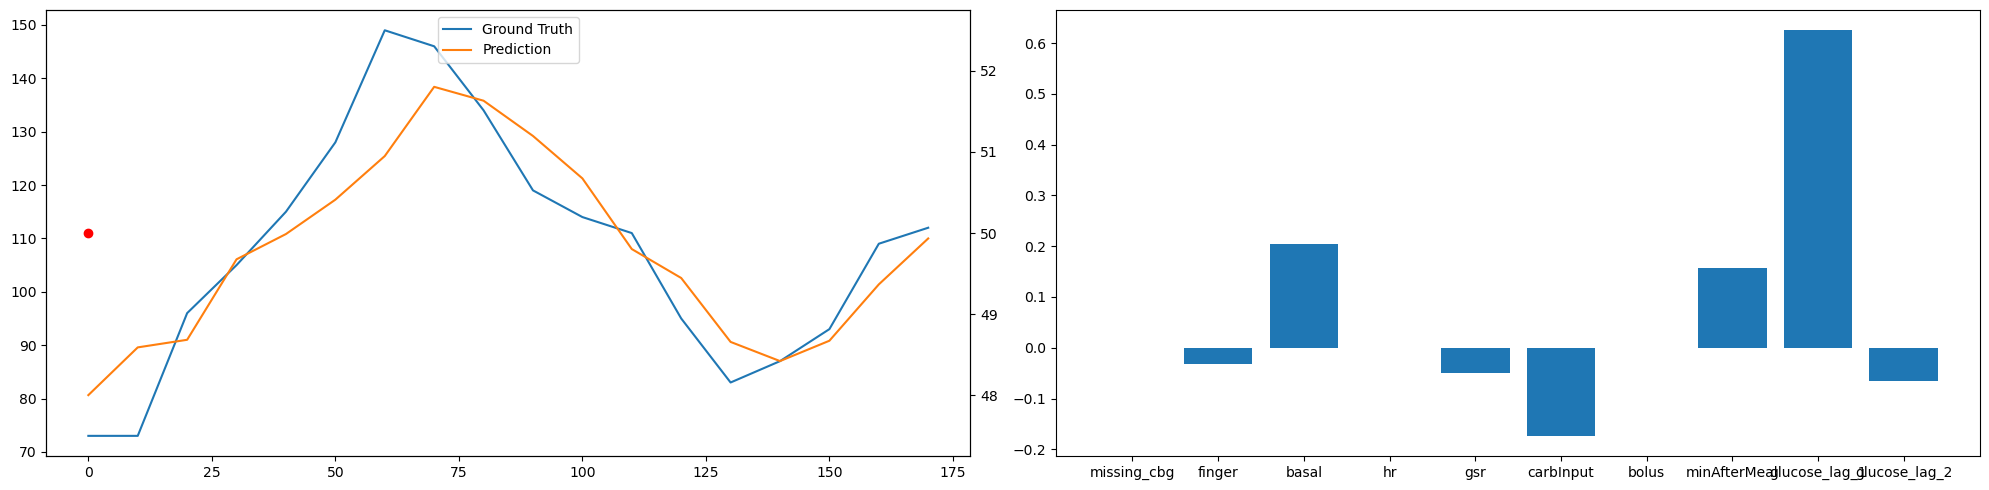

<Figure size 640x480 with 0 Axes>

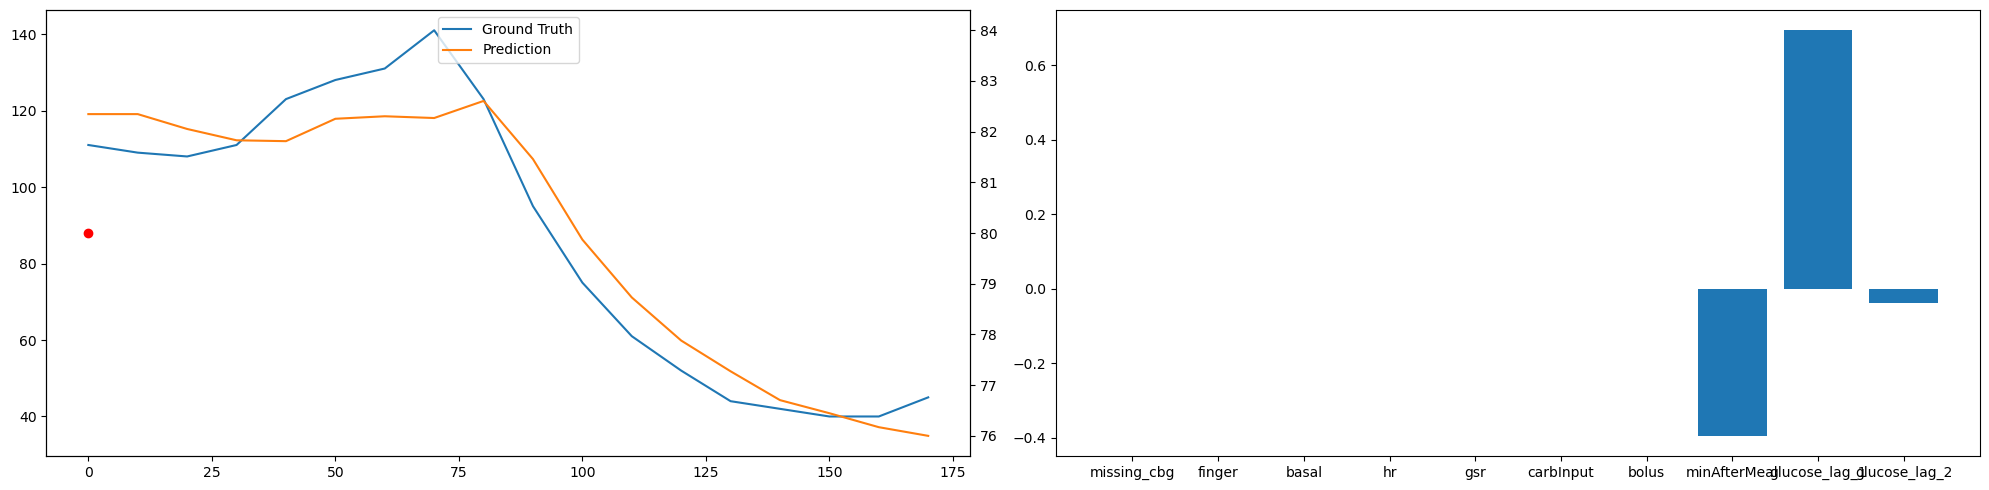

<Figure size 640x480 with 0 Axes>

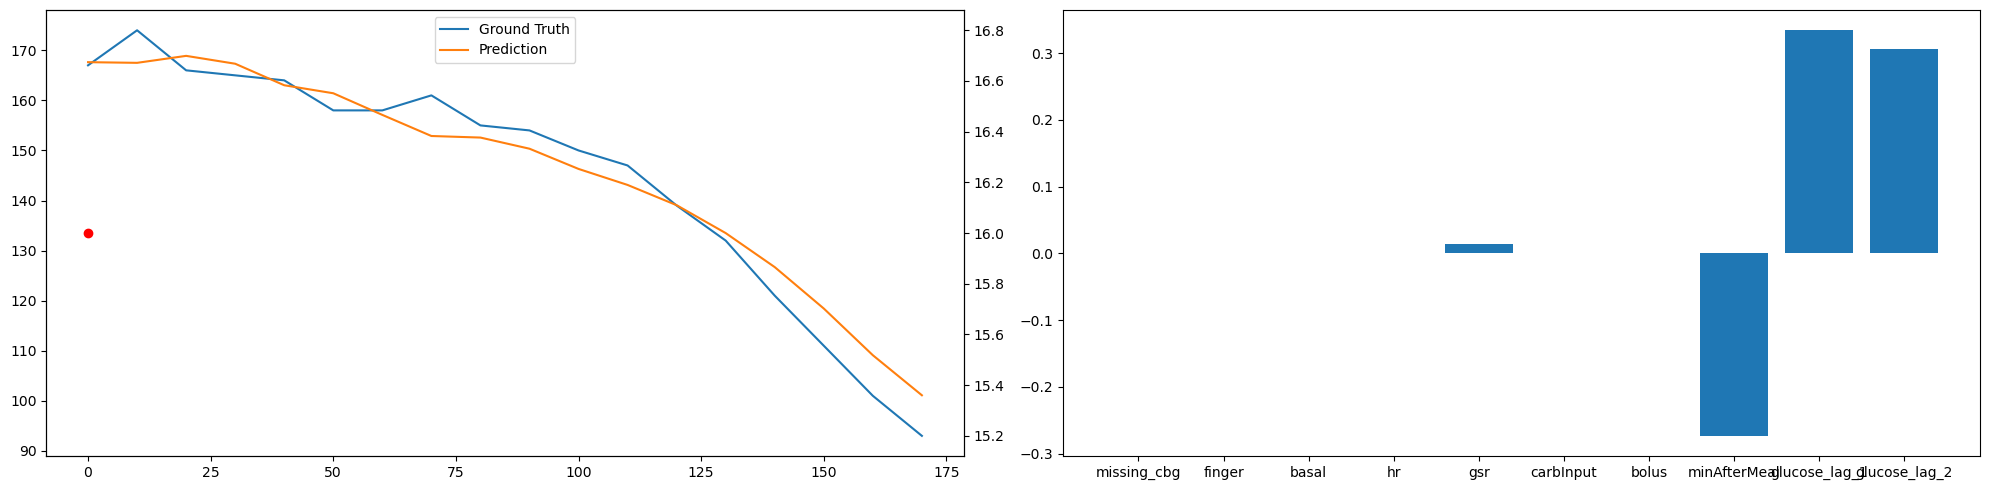

<Figure size 640x480 with 0 Axes>

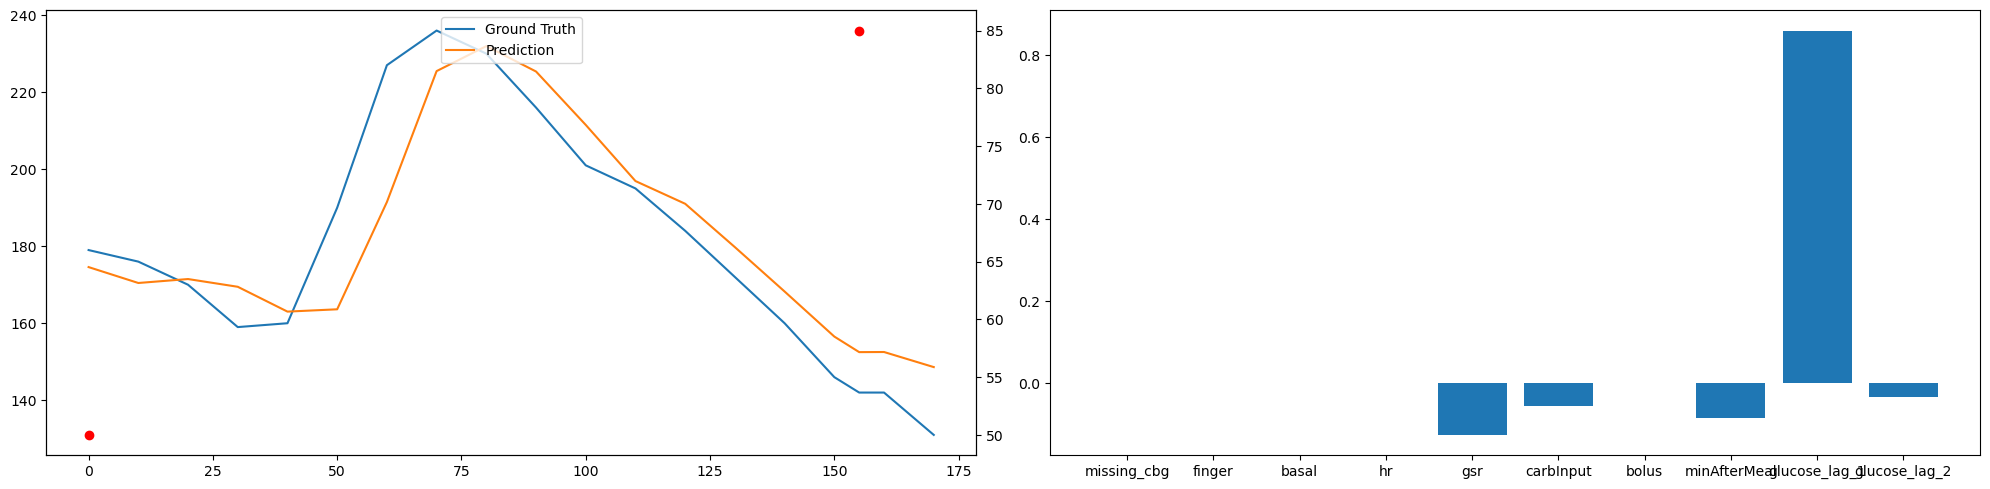

<Figure size 640x480 with 0 Axes>

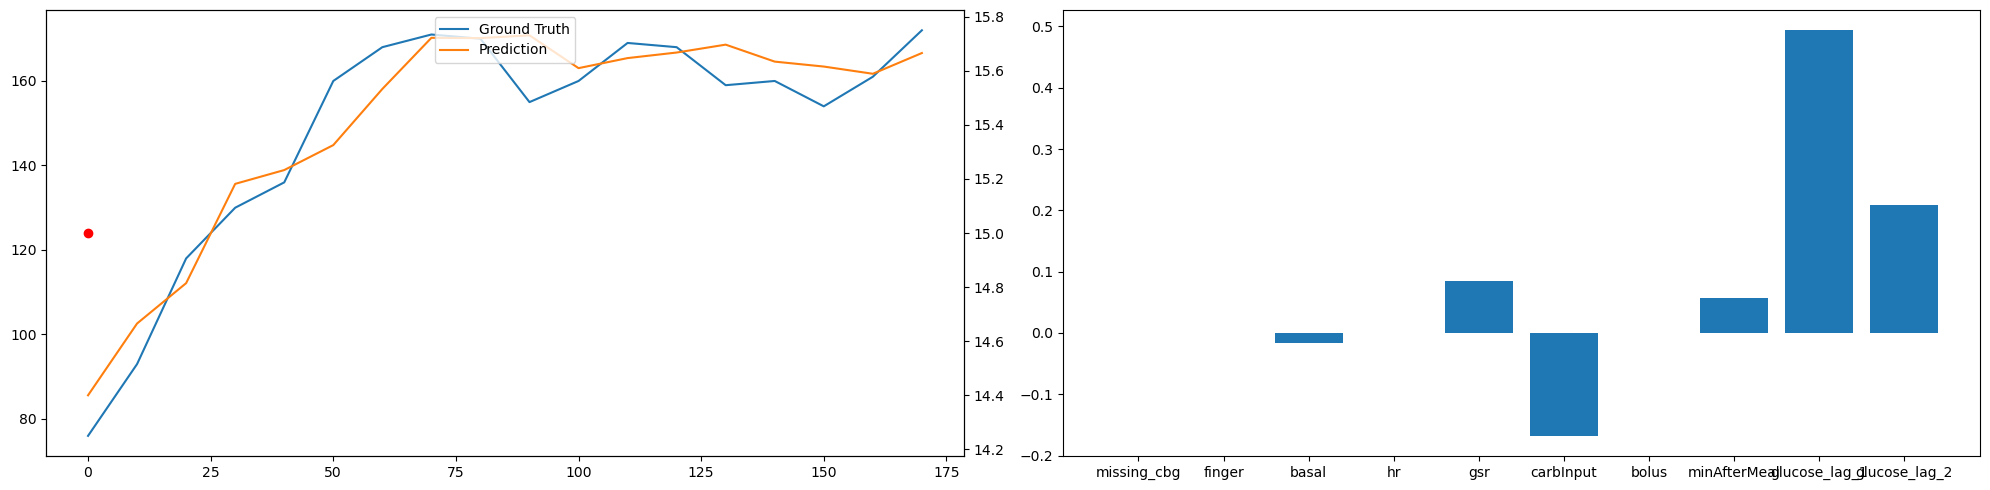

<Figure size 640x480 with 0 Axes>

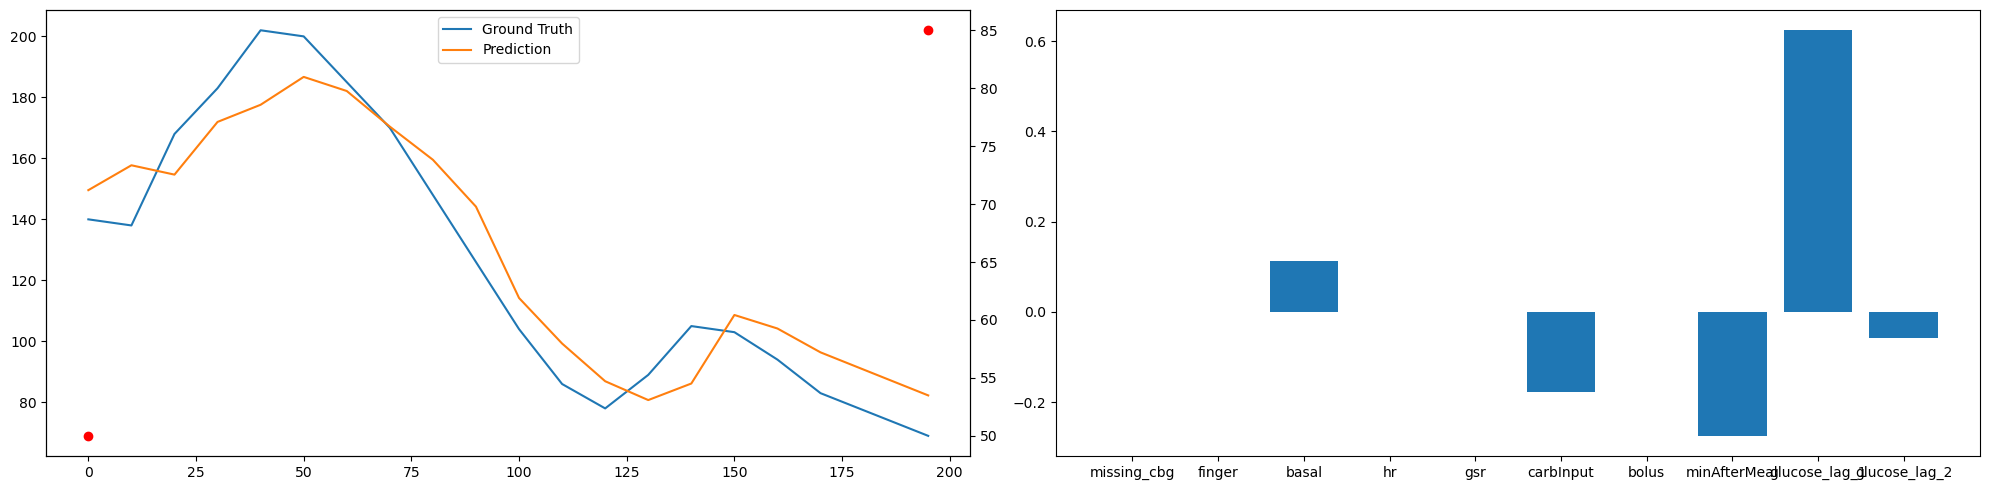

<Figure size 640x480 with 0 Axes>

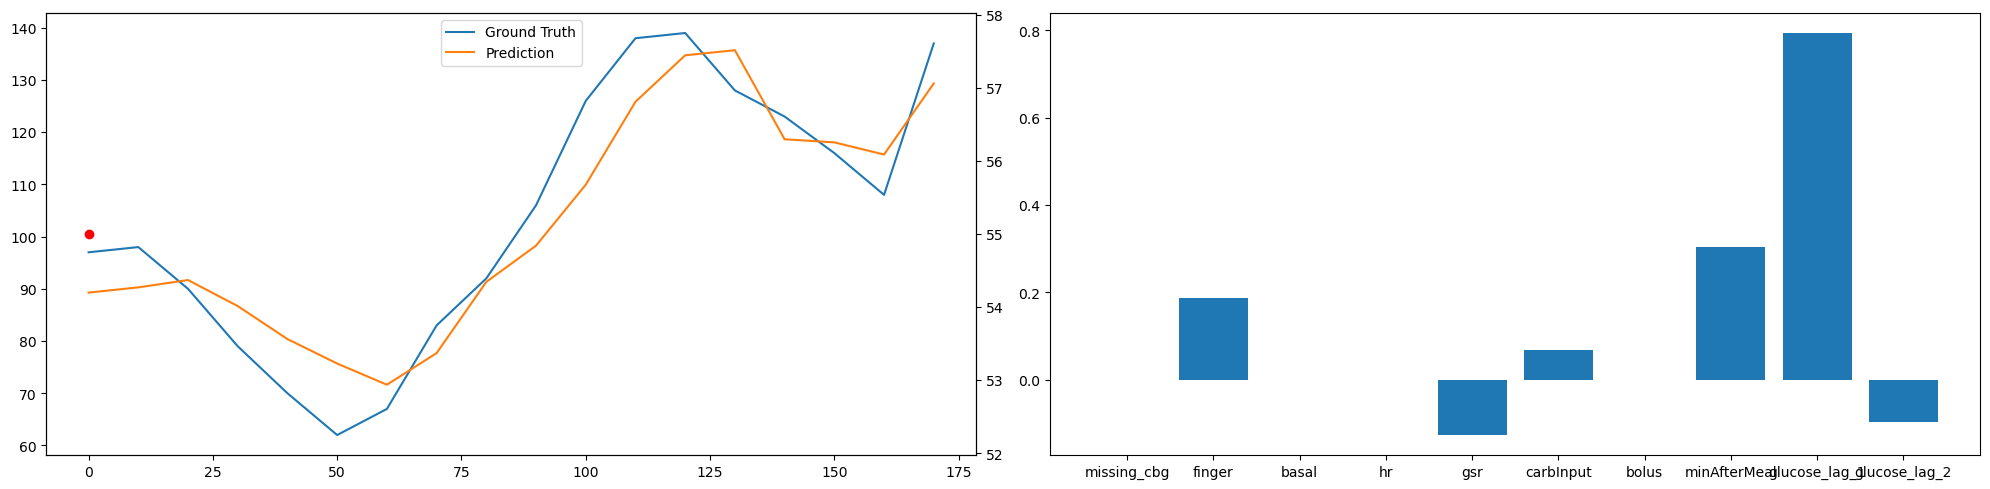

<Figure size 640x480 with 0 Axes>

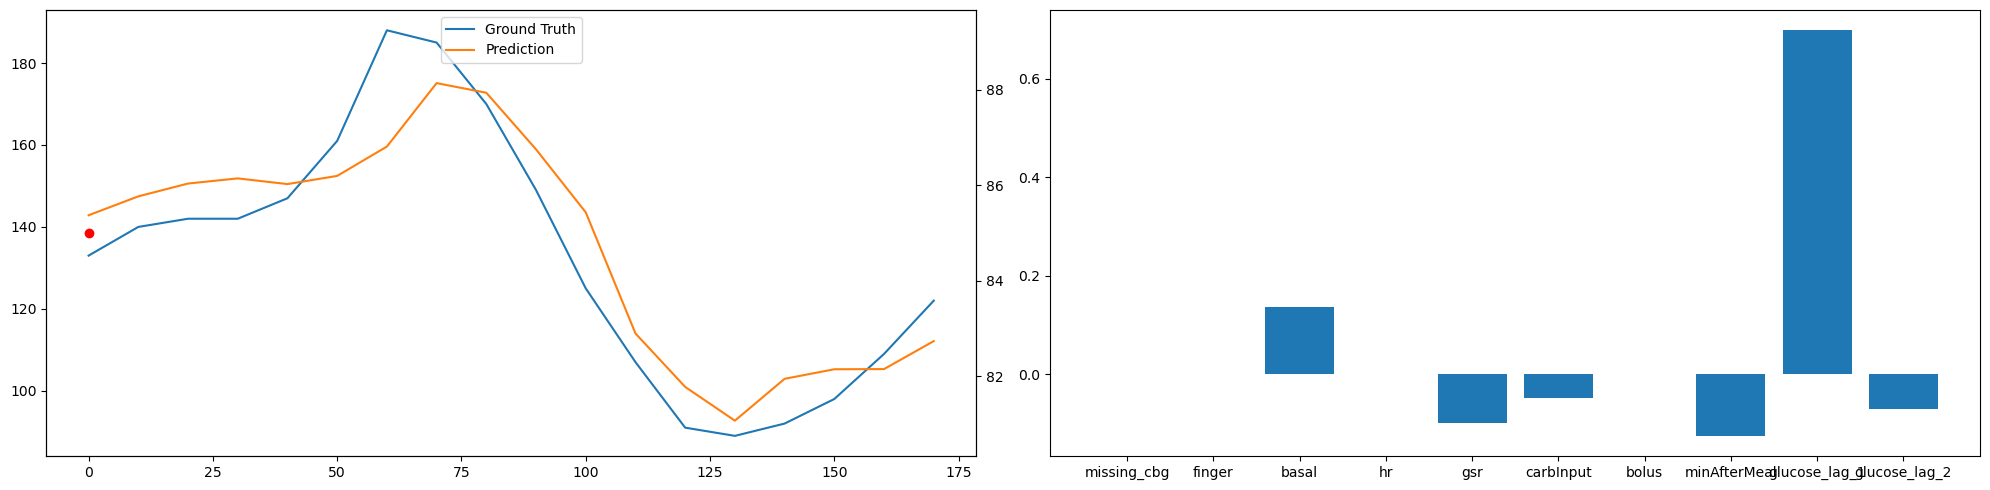

<Figure size 640x480 with 0 Axes>

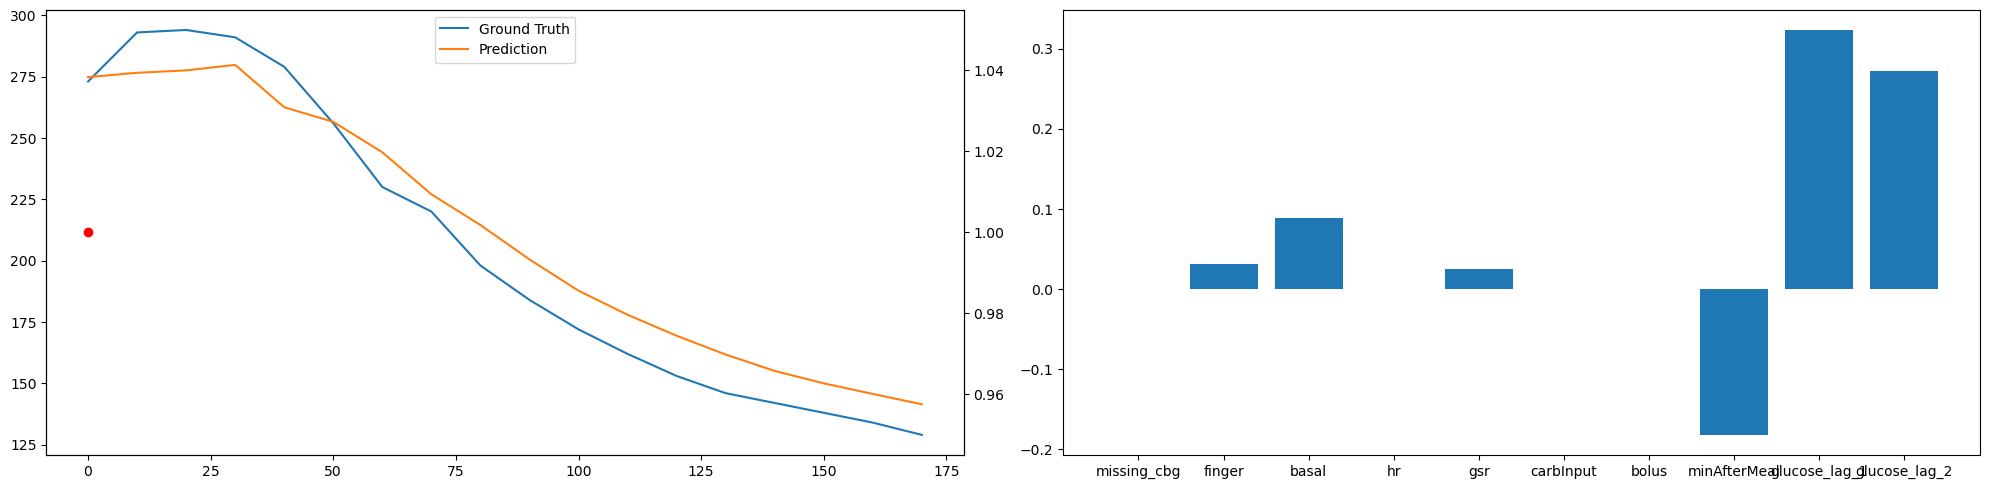

<Figure size 640x480 with 0 Axes>

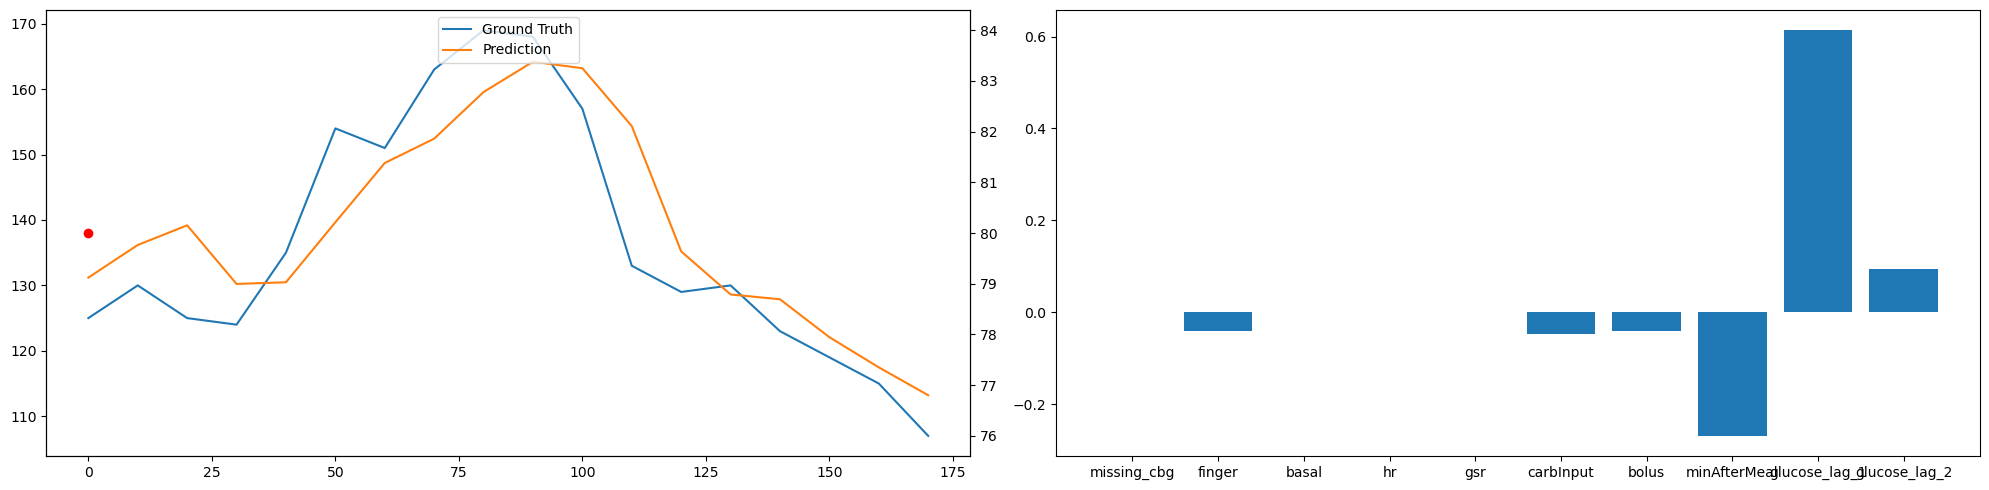

<Figure size 640x480 with 0 Axes>

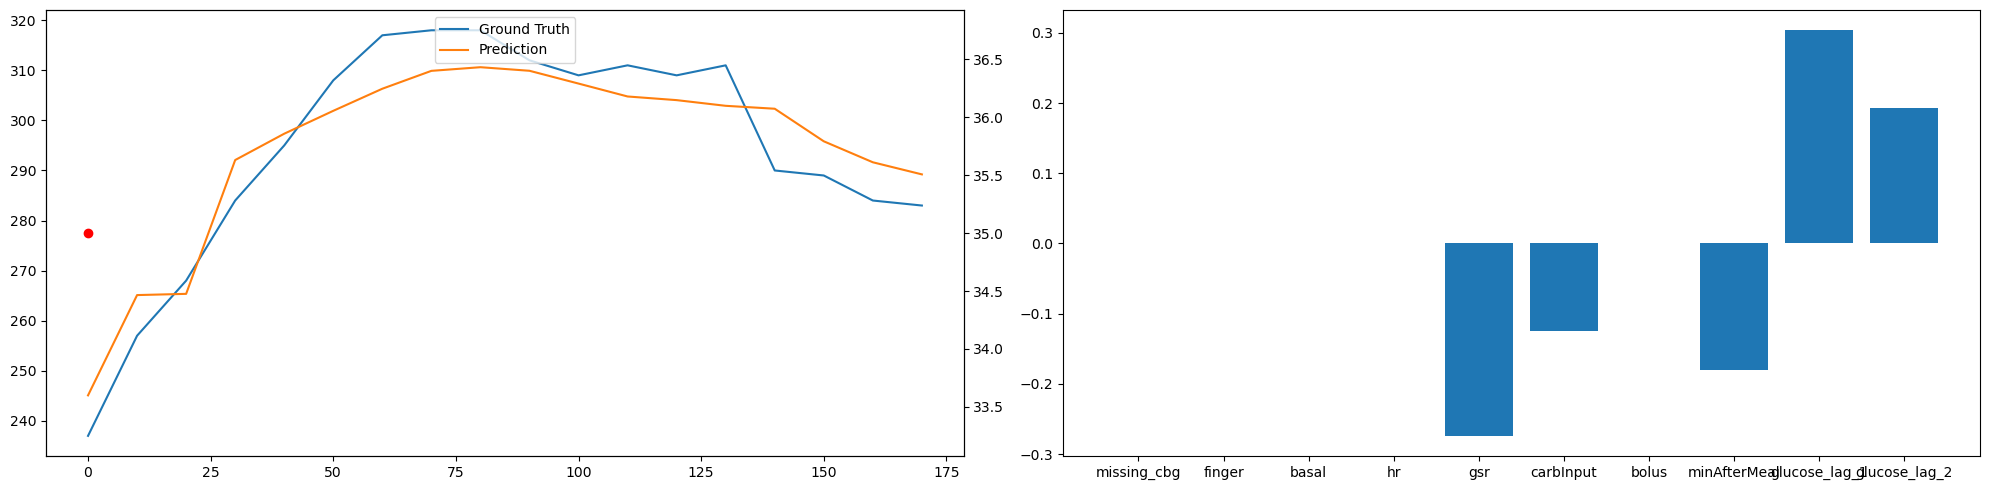

<Figure size 640x480 with 0 Axes>

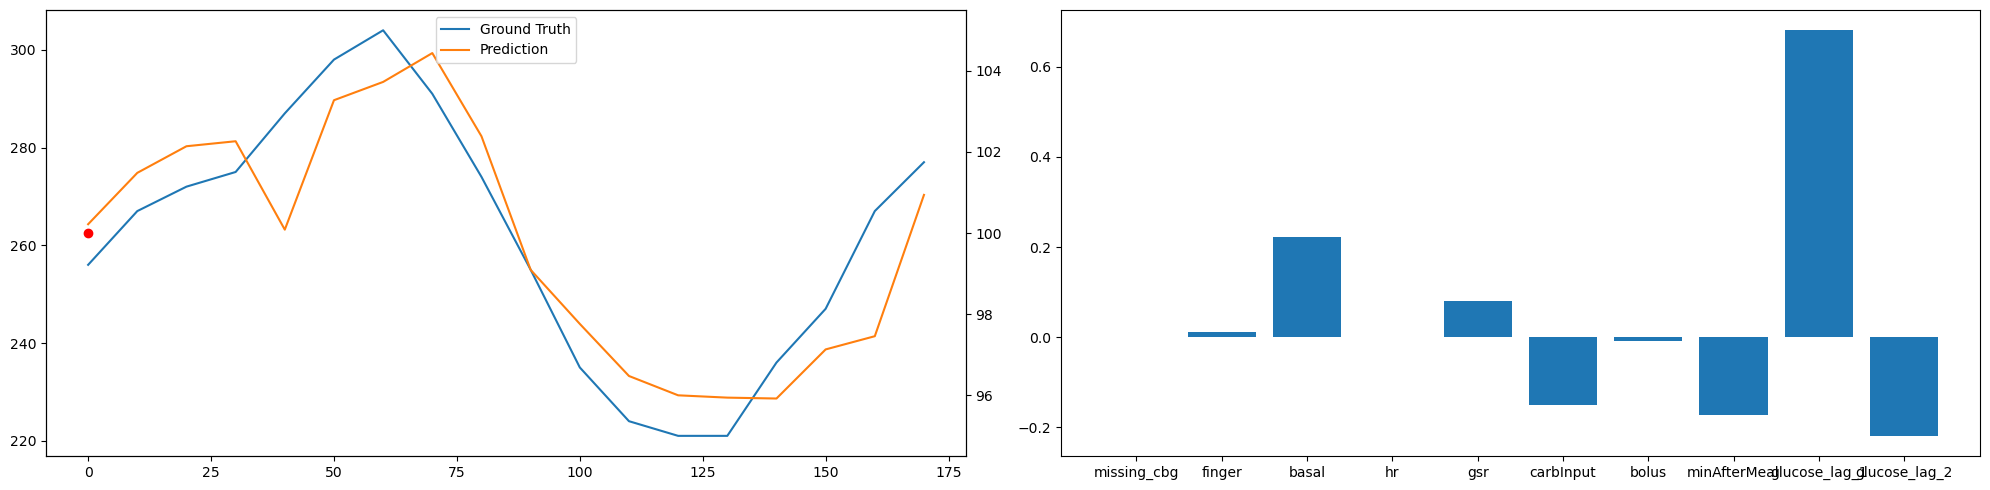

<Figure size 640x480 with 0 Axes>

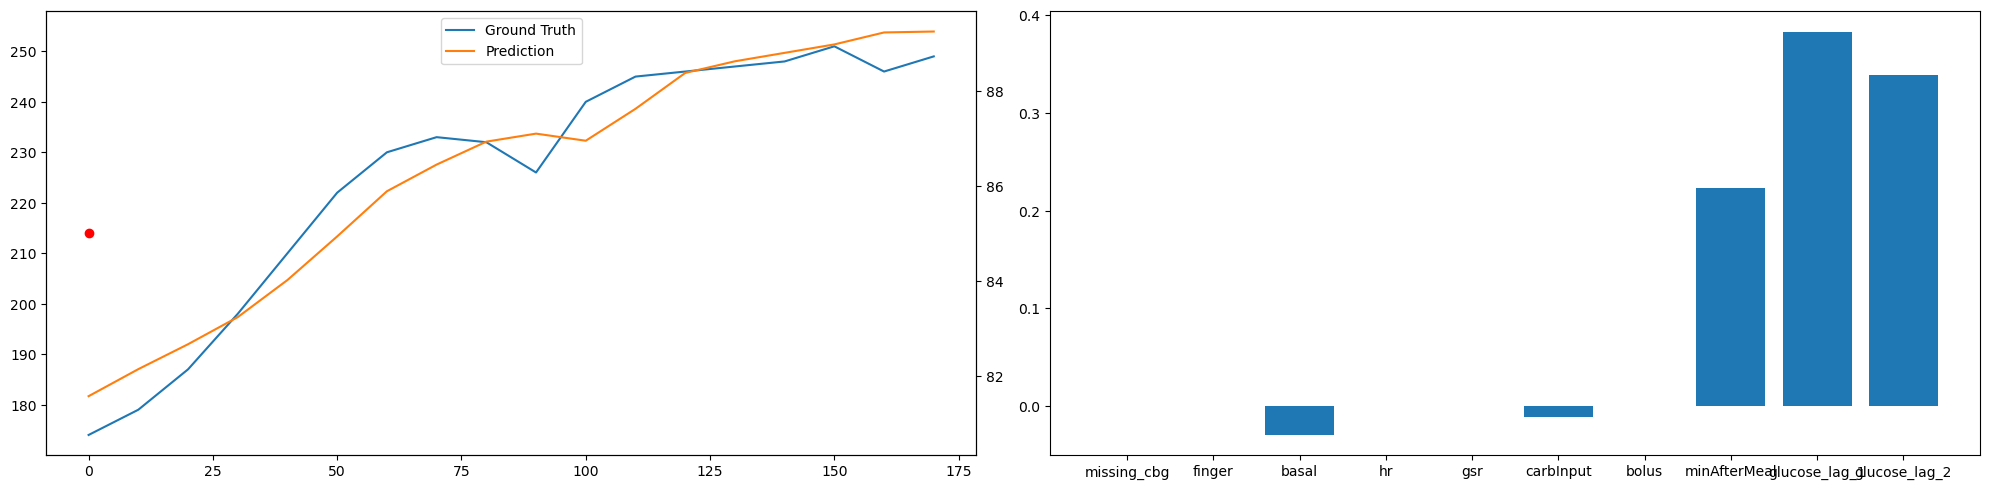

<Figure size 640x480 with 0 Axes>

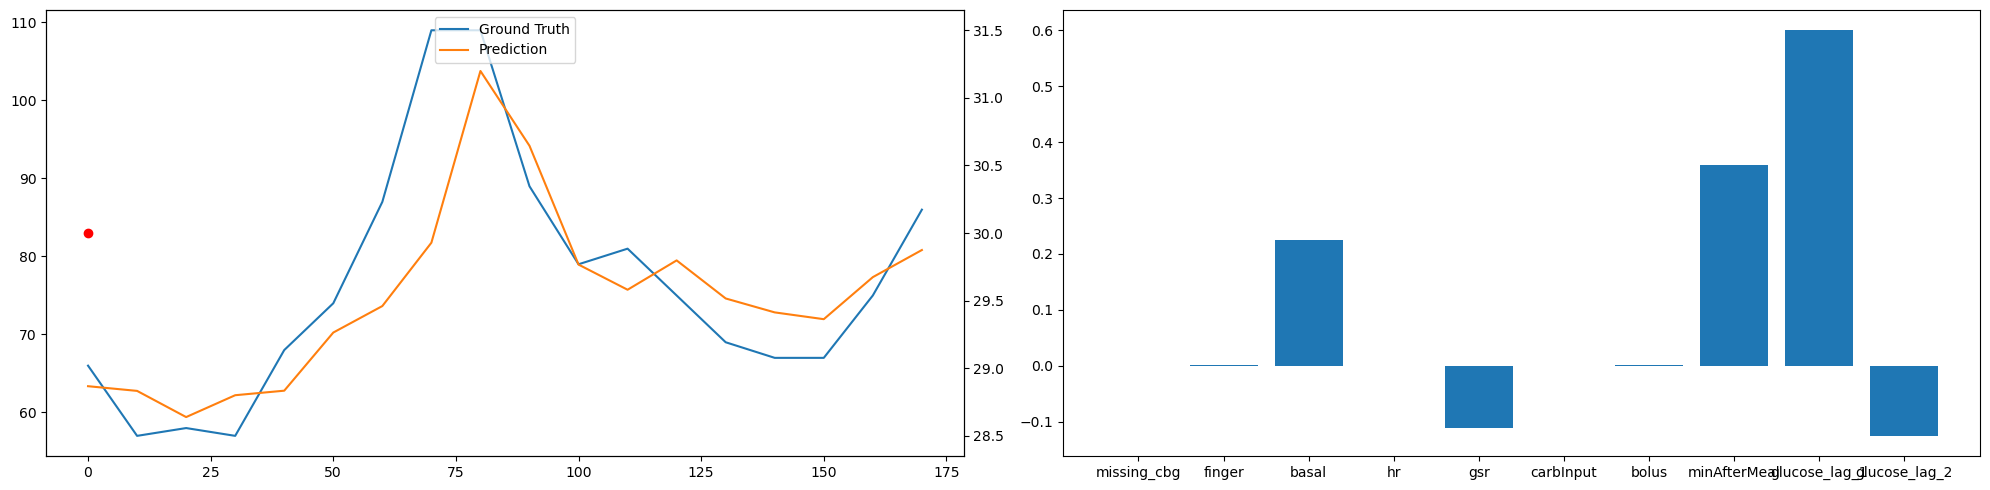

<Figure size 640x480 with 0 Axes>

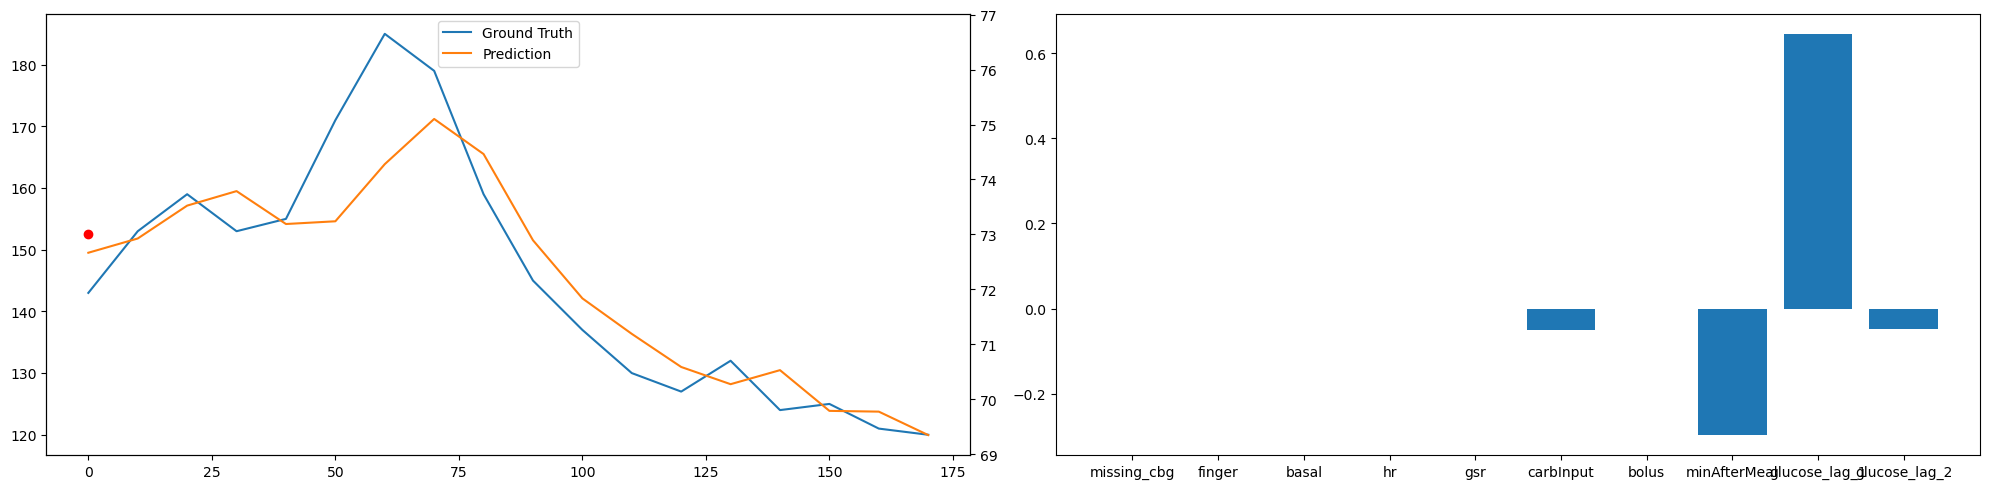

<Figure size 640x480 with 0 Axes>

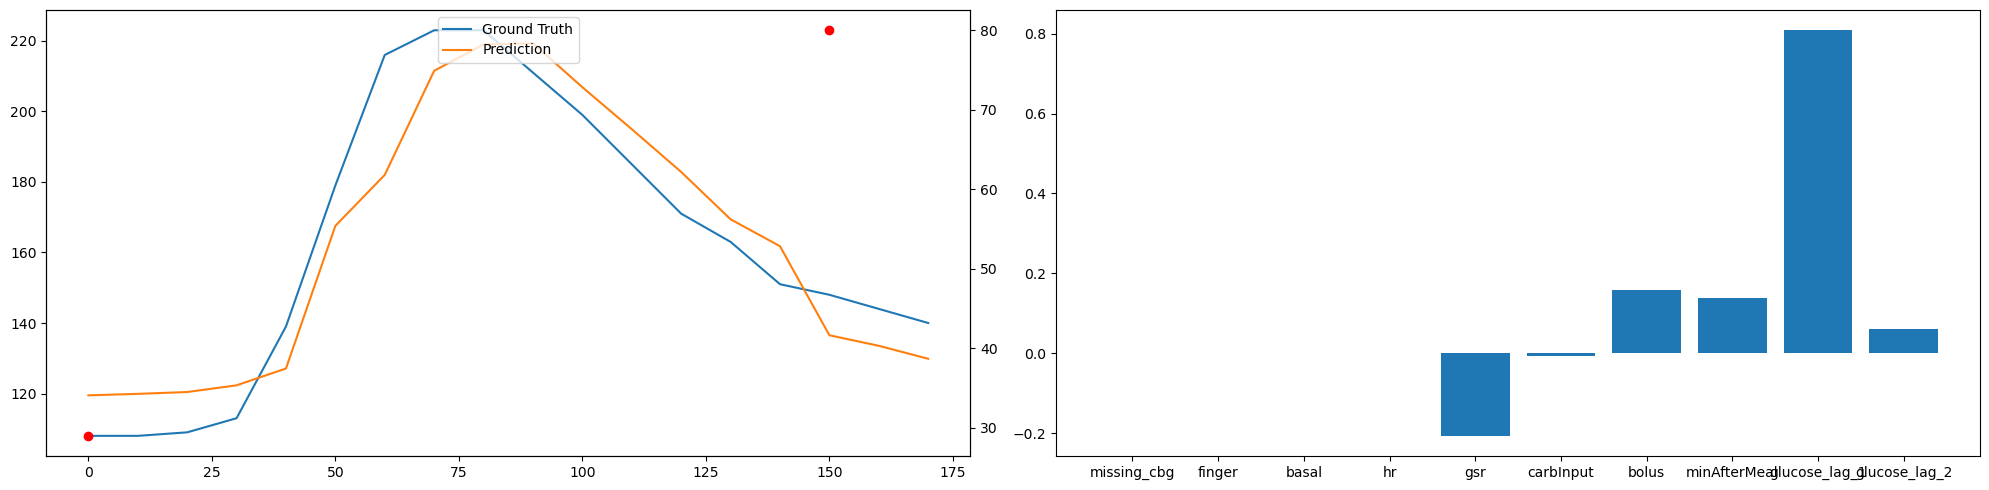

<Figure size 640x480 with 0 Axes>

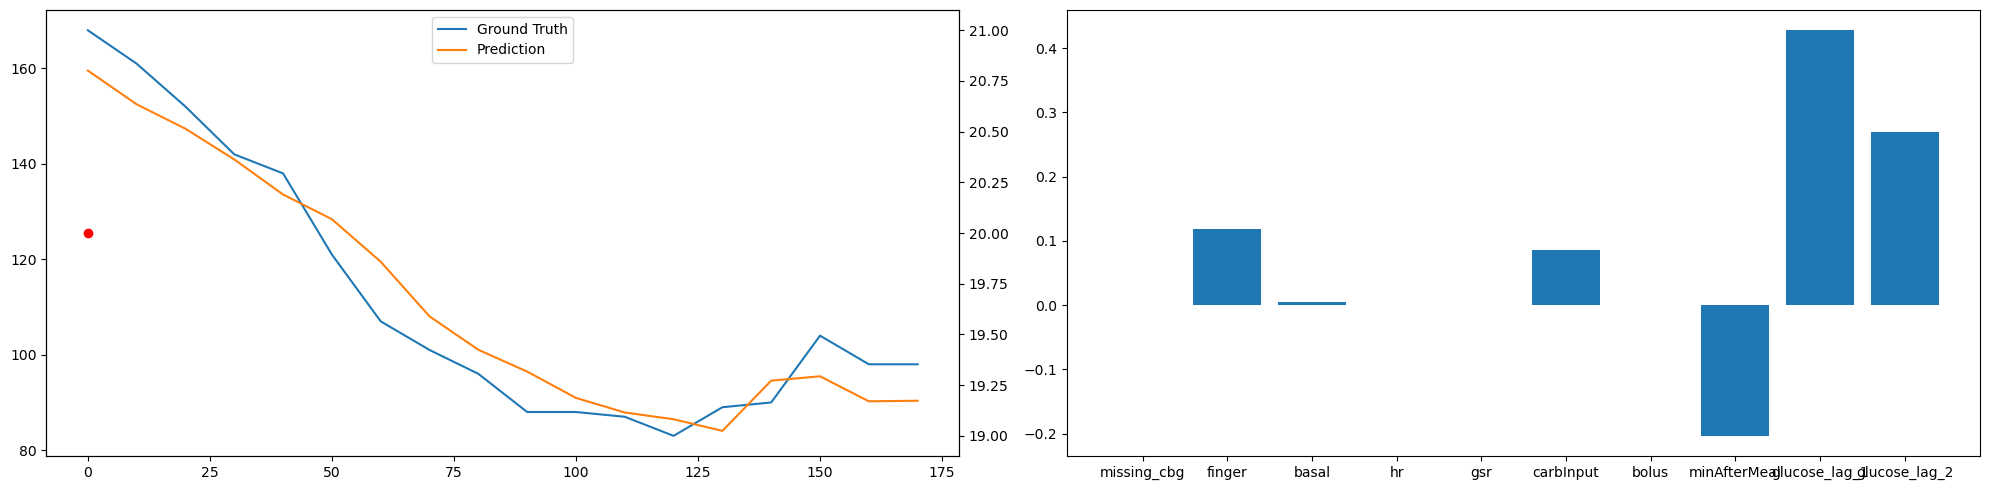

<Figure size 640x480 with 0 Axes>

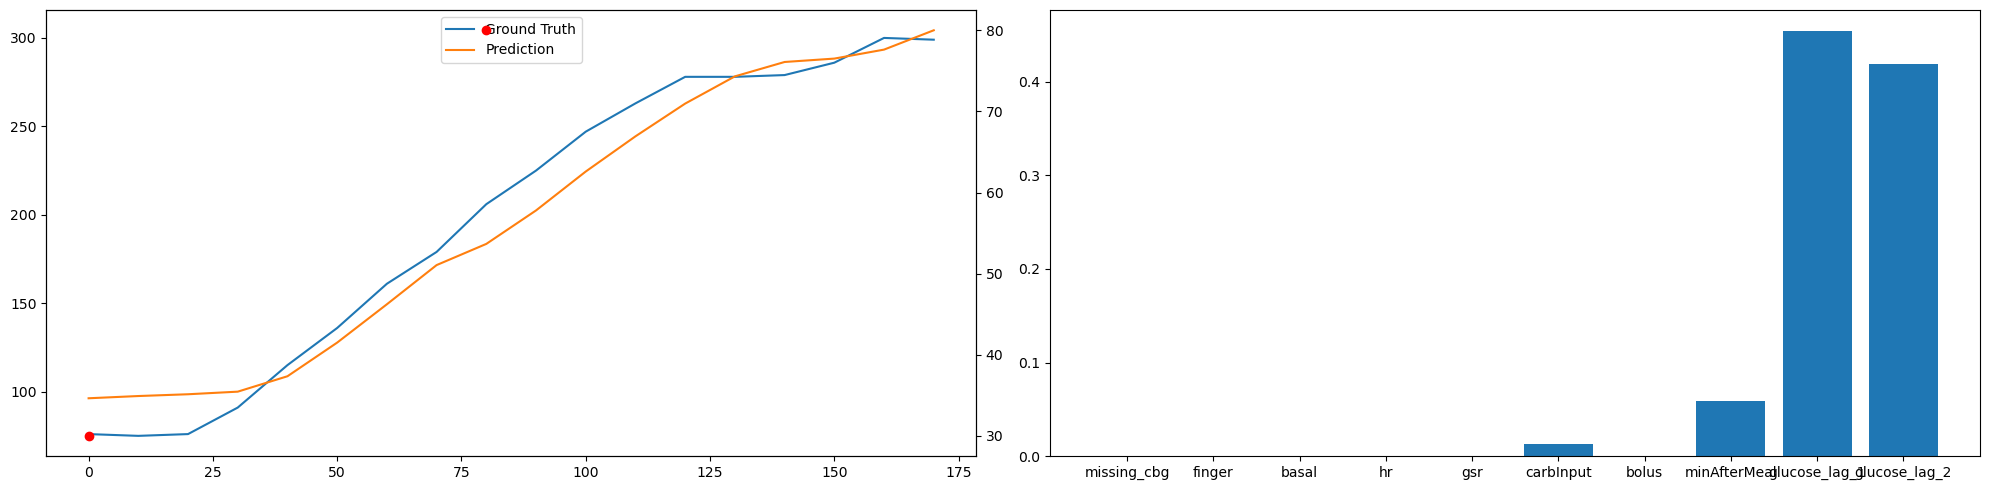

<Figure size 640x480 with 0 Axes>

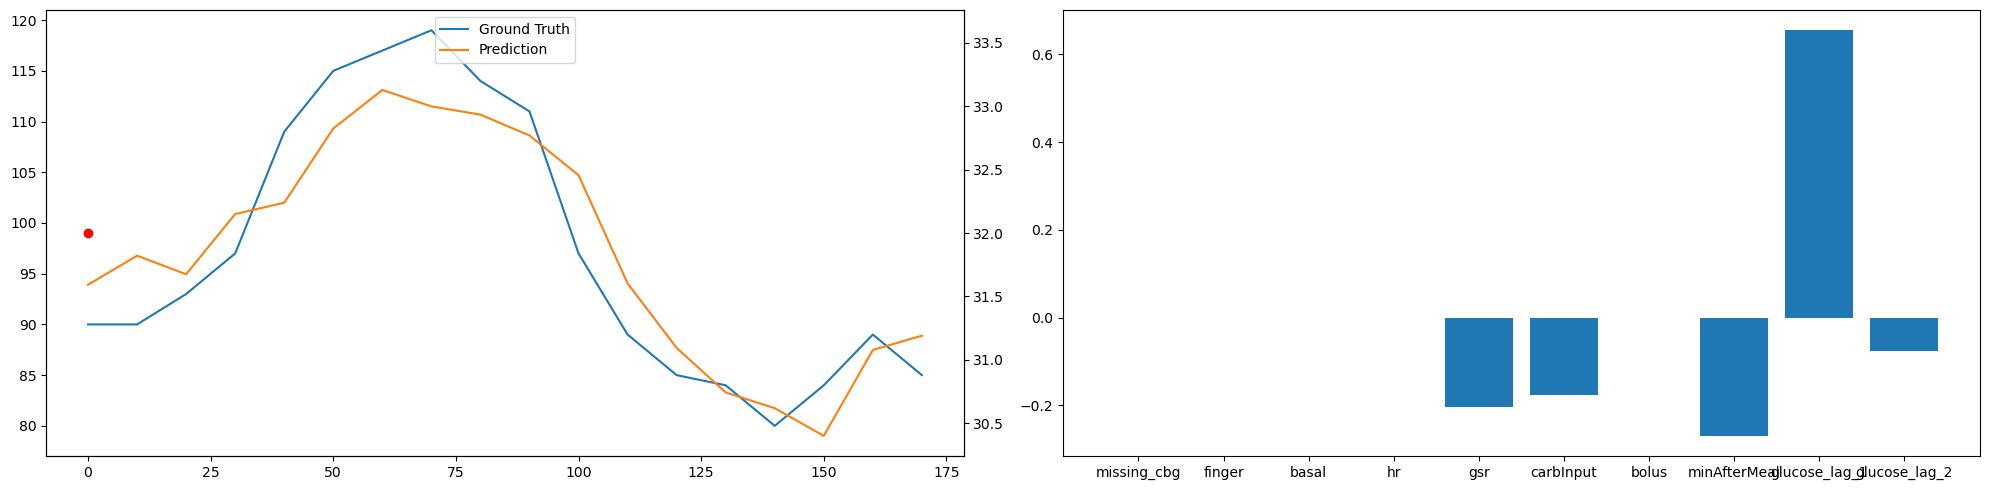

In [25]:
coef = []
model = SVR(kernel="linear")
for data in data_train:
    plt.figure()
    coef.append(train_model(data, model))

In [28]:
## Create ensemble linear regression model
totCoef = 0
for x in coef:
    totCoef += x

averageCoef = totCoef / len(coef)

In [27]:
ensemble_model = SVR(kernel="linear")
ensemble_model.coef_ = averageCoef
for data in data_test:
    plt.figure()
    train_model(data, model, train=False)
    

NameError: name 'LinearRegression' is not defined